In [1]:
import librosa
import librosa.effects
import colorednoise as cn
from pydub import AudioSegment, effects

import numpy as np
import os
import pandas as pd
import soundfile as sf
import torch
import fastai.torch_core
from fastai.vision.all import *
import matplotlib.pyplot as plt
from pathlib import Path
import requests
import zipfile
import IPython.display as ipd
import random
import shutil
import imageio
import matplotlib.cm as cm

/home/bjorn/miniconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/bjorn/miniconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/bjorn/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# setup

In [2]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# or Kaggle, which makes some difference for the code below.

DATA_DIR = Path(os.getcwd())
try:
    import google.colab
    colab=True
    
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATA_DIR = Path('/content/gdrive/MyDrive/DAT255')
except:
    DATA_DIR = DATA_DIR / '..' / 'data'
    colab=False
    
DATA_DIR.mkdir(parents=True, exist_ok=True)

SUB_DIRS = ['external','interim','processed','raw']    

for d in SUB_DIRS:
    dir_path = DATA_DIR / d
    dir_path.mkdir(parents=True, exist_ok=True)
    
DATA_DIR
    

Path('/home/bjorn/git/dat255-audio_project-g11/notebooks/../data')

In [3]:
if torch.backends.mps.is_available():
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [4]:
device = None
if torch.cuda.is_available():
    device = fastai.torch_core.default_device('cuda')
elif torch.backends.mps.is_available():
    device = fastai.torch_core.default_device('mps')
else:
    device = fastai.torch_core.default_device('cpu')
    
device

device(type='cuda', index=0)

# Download data

In [5]:
from src.data.download_data import download_all

meta = download_all(DATA_DIR / "external")

FSDKaggle2018 already downloaded, skipping download
FSDKaggle2018 already downloaded, skipping download
FSDKaggle2018 already downloaded, skipping download
Downloaded and unzipped FSDKaggle2018 dataset
IRMAS dataset already downloaded
VocalSet dataset already downloaded
MISD dataset already downloaded


In [6]:
meta.head()

fname         label  \
0  00044347.wav        Hi-hat   
1  001ca53d.wav     Saxophone   
2  002d256b.wav       Trumpet   
3  0033e230.wav  Glockenspiel   
4  00353774.wav         Cello   

                                                                                                                       path  \
0  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00044347.wav   
1  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/001ca53d.wav   
2  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/002d256b.wav   
3  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0033e230.wav   
4  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00353774.wav   

  dataset  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

- Lets sort out non-musical labels

In [7]:
# first print all the labels in the dataset
labels = meta['label'].unique()
print(labels)

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping' 'Vocal' 'Guitar' 'Drums' 'Piano' 'Organ'
 'Electric_guitar']


In [8]:
# musical labels
musical_labels = ['Hi-hat', 
                  'Saxophone',
                  'Trumpet', 
                  'Glockenspiel', 
                  'Cello',
                  'Clarinet',
                  'Snare_drum',
                  'Oboe', 
                  'Flute',
                  'Chime', 
                  'Bass_drum',
                  'Harmonica', 
                  'Gong',
                  'Double_bass',
                  'Tambourine', 
                  'Cowbell', 
                  'Electric_piano',
                  'Acoustic_guitar', 
                  'Violin_or_fiddle',
                  'Finger_snapping', 
                  'Vocal',
                  'Electric_guitar',
                  'Organ',
                  'Piano',
                  'Drums',
                  'Guitar'
                  ]

In [9]:
# Then we can filter the dataset to only include the musical labels
musical_meta = meta[meta['label'].isin(musical_labels)]

In [10]:
# Print non-musical labels
non_musical_labels = [label for label in labels if label not in musical_labels]
print(non_musical_labels)

['Knock', 'Gunshot_or_gunfire', 'Computer_keyboard', 'Keys_jangling', 'Writing', 'Laughter', 'Tearing', 'Fart', 'Cough', 'Telephone', 'Bark', 'Bus', 'Squeak', 'Scissors', 'Microwave_oven', 'Burping_or_eructation', 'Shatter', 'Fireworks', 'Meow', 'Drawer_open_or_close', 'Applause']


# mixing audio clips

- Experimenting with mixing audio clips

In [11]:
def mix_audio_clips(clip_paths, output_path, sr=44100):
    # Load the first clip
    mixed_clip, _ = librosa.load(clip_paths[0], sr=sr)
    
    # Load and mix each subsequent clip
    for clip_path in clip_paths[1:]:
        clip, _ = librosa.load(clip_path, sr=sr)
        # Ensure the clips are of the same length
        min_len = min(len(mixed_clip), len(clip))
        mixed_clip = mixed_clip[:min_len] + clip[:min_len]
        
    # Normalize the mixed clip to prevent clipping
    mixed_clip = mixed_clip / np.max(np.abs(mixed_clip))
    
    # Save the mixed clip to an output file
    sf.write(output_path, mixed_clip, sr)

In [12]:
# Example usage. Random path from meta
path1 = musical_meta.sample(1)['path'].values[0]
path2 = musical_meta.sample(1)['path'].values[0]

processed_path = DATA_DIR / 'processed'

# Create mixed clips directory if it doesn't exist
mixed_clips_path = os.path.join(processed_path, 'mixed_clips')
if not os.path.exists(mixed_clips_path):
    os.makedirs(mixed_clips_path)

mix_audio_clips([path1, path2], os.path.join(mixed_clips_path, 'mixed_clip.wav'))

In [13]:
# Load the mixed clip and the original clips to compare
ipd.Audio(path1)


In [14]:
ipd.Audio(path2)

In [15]:
ipd.Audio(os.path.join(mixed_clips_path, 'mixed_clip.wav'))

Works fine :)

# Frequency determination

- Want to categorize the clips into frequencies.
- Avoid muddy mixes with clips in same frequency range.
- Mimick realistic audio mixing?

In [16]:
def determine_frequency_range(audio_path, sr=44100):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Compute the short-time Fourier transform (STFT)
    D = np.abs(librosa.stft(y))
    
    # Define the frequency ranges
    ranges = {
        'sub_bass': (20, 60),
        'bass': (60, 250),
        'low_midrange': (250, 500),
        'midrange': (500, 2000),
        'upper_midrange': (2000, 4000),
        'presence': (4000, 6000),
        'brilliance': (6000, 20000),
    }
    
    # Compute the spectral energy in each range
    energy = {name: D[int(low / sr * D.shape[0]):int(high / sr * D.shape[0])].sum()
              for name, (low, high) in ranges.items()}
    
    # Determine the dominant frequency range
    return max(energy, key=energy.get)

In [17]:
# Example usage

# Two random audio clips
path1 = musical_meta.sample(1).iloc[0]['path']
path2 = musical_meta.sample(1).iloc[0]['path']

# Create a DataFrame with the paths of the two audio clips
df = pd.DataFrame({'path': [path1, path2]})

# Determine the frequency range for each clip and add it to the DataFrame
df['frequency_range'] = df['path'].apply(determine_frequency_range)

print(path1, "frequency range: " ,determine_frequency_range(path1), "instrument: ", musical_meta[musical_meta['path'] == path1]['label'].values[0])
print(path2, "frequency range: " , determine_frequency_range(path2), "instrument: ", musical_meta[musical_meta['path'] == path2]['label'].values[0])

/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/IRMAS/IRMAS-TrainingData/gac/[gac][pop_roc]0616__2.wav frequency range:  midrange instrument:  Acoustic_guitar
/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female3/scales/breathy/f3_scales_breathy_e.wav frequency range:  midrange instrument:  Vocal


In [18]:
ipd.Audio(path1)

In [19]:
ipd.Audio(path2)

- Usually works

- Now, let's add a range to all the entries.

In [20]:
# Determine the frequency range for all clips in the dataset
musical_meta = musical_meta.copy()
musical_meta.loc[:, 'frequency_range'] = musical_meta['path'].apply(determine_frequency_range)

In [21]:
musical_meta.head()

fname         label  \
0  00044347.wav        Hi-hat   
1  001ca53d.wav     Saxophone   
2  002d256b.wav       Trumpet   
3  0033e230.wav  Glockenspiel   
4  00353774.wav         Cello   

                                                                                                                       path  \
0  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00044347.wav   
1  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/001ca53d.wav   
2  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/002d256b.wav   
3  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0033e230.wav   
4  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00353774.wav   

  dataset frequency_range  
0     NaN      brilliance  
1     NaN        midrange  
2     NaN        midrange  
3     NaN  upper_midrange  
4     NaN        midrange

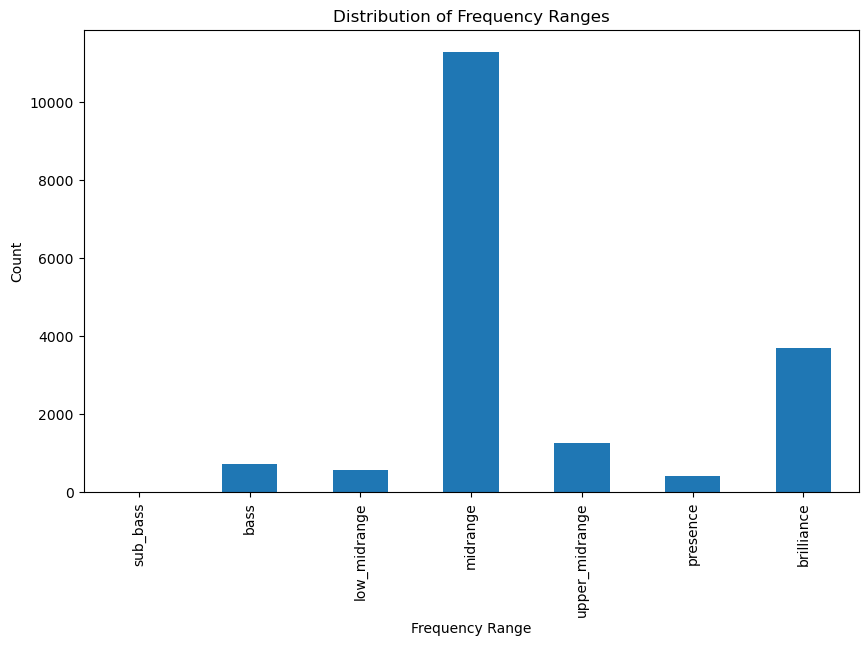

In [22]:
# Define the order of the frequency ranges from low to high
order = ['sub_bass', 'bass', 'low_midrange', 'midrange', 'upper_midrange', 'presence', 'brilliance']

# Plot the distribution of frequency ranges
plt.figure(figsize=(10, 6))
musical_meta['frequency_range'].value_counts().loc[order].plot(kind='bar')
plt.title('Distribution of Frequency Ranges')
plt.xlabel('Frequency Range')
plt.ylabel('Count')
plt.show()


# Mixing clips from different ranges

In [23]:
# Experimental genre-specific adjustments. Might not work as intended. The idea is to apply different effects to the audio clips based on the genre.
genre_instruments = {
    'jazz': ['Saxophone', 'Piano','Drums','Trumpet','Guitar', 'Double_bass', 'Snare_drum', 'Hi-hat', 'Clarinet', 'Trombone', 'Electric_piano','Vocal'],
    'classical': ['Violin_or_fiddle', 'Piano','Cello', 'Flute', 'Oboe', 'Clarinet', 'Glockenspiel', 'Chime', 'Gong', 'Organ'],
    'rock': ['Electric_piano','Guitar', 'Electric_guitar','Drums', 'Acoustic_guitar', 'Snare_drum', 'Bass_drum', 'Hi-hat', 'Tambourine', 'Cowbell','Vocal', 'Organ', 'Finger_snapping'],
    'blues': ['Saxophone', 'Trumpet','Organ', 'Harmonica','Piano', 'Electric_piano','Electric_guitar','Acoustic_guitar', 'Guitar', 'Snare_drum', 'Hi-hat','Drums','Vocal'],
    'folk': ['Acoustic_guitar','Guitar', 'Violin_or_fiddle', 'Harmonica', 'Double_bass', 'Flute', 'Tambourine', 'Glockenspiel','Vocal'],
    'electronic': ['Snare_drum', 'Bass_drum', 'Hi-hat', 'Electric_piano', 'Tambourine', 'Finger_snapping', 'Chime','Vocal','Drums',],
    'world': ['Harmonica', 'Gong', 'Tambourine', 'Cowbell', 'Oboe', 'Chime', 'Flute', 'Double_bass','Vocal'],
    'wildcard': ['Hi-hat', 
                  'Saxophone',
                  'Trumpet', 
                  'Glockenspiel', 
                  'Cello',
                  'Clarinet',
                  'Snare_drum',
                  'Oboe', 
                  'Flute',
                  'Chime', 
                  'Bass_drum',
                  'Harmonica', 
                  'Double_bass',
                  'Tambourine', 
                  'Cowbell', 
                  'Electric_piano',
                  'Acoustic_guitar', 
                  'Violin_or_fiddle',
                  'Finger_snapping', 
                  'Vocal',
                  'Electric_guitar',
                  'Organ',
                  'Piano',
                  'Drums',
                  'Guitar'
                  ]
}

# Map instruments to more general categories
instrument_map = {
    'Snare_drum': 'Snare_drum', 'Bass_drum': 'Bass_drum', 'Hi-hat': 'Hi-hat',
    'Tambourine': 'Tambourine', 'Gong': 'Gong', 'Cowbell': 'Cowbell',
    'Violin_or_fiddle': 'Violin_or_fiddle', 'Cello': 'Cello', 'Double_bass': 'Bass',
    'Acoustic_guitar': 'Acoustic_guitar', 'Guitar': 'Guitar','Electric_guitar': 'Electric_guitar','Electric_piano': 'Electric_piano', 'Flute': 'Flute',
    'Clarinet': 'Clarinet', 'Oboe': 'Oboe', 'Saxophone': 'Saxophone', 
    'Trumpet': 'Trumpet', 'Trombone': 'Trombone', 'Harmonica': 'Harmonica',
    'Glockenspiel': 'Glockenspiel', 'Chime': 'Chime',
    'Electric_piano': 'Electric_piano', 'Synthesizers': 'Synthesizers', 'Drum_machine': 'Drums',
    'Finger_snapping': 'Finger_snapping', 'Vocal': 'Vocal', 'Piano':'Piano', 'Organ':'Organ', 'Drums':'Drums'
}

# Function to map labels in your DataFrame
def map_instrument_labels(row):
    labels = row['label'].split(', ')
    generalized_labels = set(instrument_map[label] for label in labels if label in instrument_map)
    return ', '.join(generalized_labels)

# Applying the mapping to your DataFrame
musical_meta['generalized_label'] = musical_meta.apply(map_instrument_labels, axis=1)

In [24]:
musical_meta.head()

fname         label  \
0  00044347.wav        Hi-hat   
1  001ca53d.wav     Saxophone   
2  002d256b.wav       Trumpet   
3  0033e230.wav  Glockenspiel   
4  00353774.wav         Cello   

                                                                                                                       path  \
0  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00044347.wav   
1  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/001ca53d.wav   
2  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/002d256b.wav   
3  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0033e230.wav   
4  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00353774.wav   

  dataset frequency_range generalized_label  
0     NaN      brilliance            Hi-hat  
1     NaN        midrange         Saxophone  
2     NaN        midrange           Trumpet  
3     NaN  upper_midrange      Glockenspiel  
4     NaN        midrange             Cello

In [31]:
def adjust_for_genre(clip, genre, sr=44100):
    if genre == 'classical':
        # Increase dynamic range; classical music often has wide dynamic swings
        clip = clip * (1 + np.var(clip))
    elif genre == 'rock':
        # Apply compression to decrease dynamic range; rock music often has a compressed, upfront sound
        clip = librosa.effects.preemphasis(clip)
    elif genre == 'jazz':
        # Slightly increase dynamic range and add a subtle reverb to emulate live jazz environments
        clip = clip * (1 + 0.5 * np.var(clip))
        clip = librosa.effects.preemphasis(clip, coef=0.97)  # Slight pre-emphasis
    elif genre == 'blues':
        # Apply mild compression and a warmer tone by reducing high frequencies
        clip = librosa.effects.preemphasis(clip, coef=0.95)
    elif genre == 'folk':
        # Enhance the natural dynamics and apply a gentle high-pass filter to emulate acoustic settings
        clip = librosa.effects.hpss(clip)[1]
    elif genre == 'electronic':
        # Normalize to ensure uniform loudness levels typical of electronic music
        clip = librosa.util.normalize(clip)
    elif genre == 'world':
        # Apply a slight increase in dynamic range and a moderate reverb to reflect diverse instrumentation and spaces
        clip = clip * (1 + 0.3 * np.var(clip))
    elif genre == 'wildcard':
        # For wildcard, randomly choose to apply one of the effects mildly to not bias the genre
        effects = [lambda x: x, lambda x: librosa.effects.preemphasis(x, coef=0.98), lambda x: x * (1 + 0.2 * np.var(x)), librosa.util.normalize]
        clip = random.choice(effects)(clip)

    return clip


def add_noise(clip, noise_type='white', snr=20):
    if noise_type == 'white':
        # Generate white noise
        noise = np.random.normal(0, 1, len(clip))
    elif noise_type == 'pink':
        # Generate pink noise using colorednoise
        # The exponent for pink noise is 1, beta = 1
        noise = cn.powerlaw_psd_gaussian(1, len(clip))
    elif noise_type == 'brownian':
        # Generate brownian noise using colorednoise
        # The exponent for brownian noise is 2, beta = 2
        noise = cn.powerlaw_psd_gaussian(2, len(clip))
    else:
        # TODO: Load custom noise file. For now do nothing
        return clip
    
    # Calculate signal and noise power, then scale noise to achieve the desired SNR
    sig_power = np.sum(clip ** 2) / len(clip)
    noise_power = np.sum(noise ** 2) / len(noise)
    scale = (sig_power / noise_power) / (10 ** (snr / 10))
    noise = noise * np.sqrt(scale)
    
    return clip + noise

def random_slice_reassemble(audio_segment, num_slices=4):
    slice_length = len(audio_segment) // num_slices
    slices = [audio_segment[i * slice_length:(i + 1) * slice_length] for i in range(num_slices)]
    random.shuffle(slices)
    return sum(slices)

def vary_speed(clip, sr, min_speed=0.9, max_speed=1.1):
    speed_factor = random.uniform(min_speed, max_speed)
    return librosa.effects.time_stretch(clip, rate=speed_factor)

def get_random_clip(full_clip, sr, clip_length, silence_threshold=0.01, max_attempts=10):
    # If the full clip is shorter than the desired length, return the full clip
    if len(full_clip) <= sr * clip_length:
        return full_clip

    for _ in range(max_attempts):
        start = random.randint(0, len(full_clip) - sr * clip_length)
        clip = full_clip[start : start + sr * clip_length]
        
        # If the maximum absolute value in the clip is above the threshold, return the clip
        if np.max(np.abs(clip)) > silence_threshold:
            return clip
    
    # If no non-silent clip was found after max_attempts, return None
    return None

def mix_clips_from_different_ranges(df, genre_instruments, output_file_name, sr=44100, clip_length=3, min_groups=3, max_groups=8):
    # Randomly select a genre
    genre = random.choice(list(genre_instruments.keys()))
    instruments = genre_instruments[genre]

    # Filter df for the selected instruments
    df_genre = df[df['label'].isin(instruments)]

    grouped = df_genre.groupby('frequency_range')  # Group the clips by frequency range
    num_groups = random.randint(min_groups, max_groups)
    selected_groups = random.sample(list(grouped.groups), min(num_groups, len(grouped.groups)))

    selected_clips = []
    used_instruments = set()
    for group in selected_groups:
        group_df = grouped.get_group(group)
        group_df = group_df[~group_df['label'].isin(used_instruments)]  # Exclude used instruments
        if not group_df.empty:
            selected_clip = group_df.sample(1).iloc[0]
            selected_clips.append(selected_clip)
            used_instruments.add(selected_clip['label'])

    mixed_clip = np.zeros(int(sr * clip_length))

    for row in selected_clips:
        full_clip, _ = librosa.load(row['path'], sr=sr)
    
        # Randomly select a non-silent portion of the clip
        clip = get_random_clip(full_clip, sr, clip_length)
        if clip is None:
            continue
        
        clip = adjust_for_genre(clip, genre)  # Add genre-specific adjustments
        
        # Randomly vary the speed of the clip
        if random.random() < 0.5:
            clip = vary_speed(clip, sr=sr)
        
        #Randomly slice and reassemble the clip
        if random.random() < 0.3:
            clip = random_slice_reassemble(clip)
        
        # Randomly add noise
        if random.random() < 0.5:  # Chance of adding noise
            noise_types = ['white', 'pink', 'custom', 'brownian']
            noise_type = random.choice(noise_types)  # Randomly select the type of noise to add
            clip = add_noise(clip, noise_type=noise_type)
        
        if len(clip) < len(mixed_clip):
            clip = np.tile(clip, int(np.ceil(len(mixed_clip) / len(clip))))[:len(mixed_clip)]
        mixed_clip += clip[:len(mixed_clip)]
        
    mixed_clip = mixed_clip / np.max(np.abs(mixed_clip))
    output_path = f"{output_file_name}.wav"
    sf.write(output_path, mixed_clip, sr)

    return [row['generalized_label'] for row in selected_clips], genre, output_path


In [32]:
# Example mixed clip
output_path = os.path.join(mixed_clips_path, 'mixed_clip_from_different_ranges')
mix_clips_from_different_ranges(musical_meta, genre_instruments, output_path, sr=44100)

(['Acoustic_guitar',
  'Violin_or_fiddle',
  'Bass',
  'Vocal',
  'Tambourine',
  'Glockenspiel'],
 'folk',
 '/home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_from_different_ranges.wav')

In [33]:
# Play the clip
ipd.Audio(output_path + '.wav')

In [34]:
def clear_directory(folder_path):
    # Check if the directory exists
    if not os.path.exists(folder_path):
        print(f"The directory {folder_path} does not exist.")
        return
    
    # Loop through all items in the directory
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # If it's a file or symlink, delete it
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            # If it's a directory, delete it and all its contents
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

from tqdm import tqdm

def generate_mixed_clips(df, genre_instruments, output_folder, n_clips, sr=44100, clip_length=3):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    elif os.listdir(output_folder):
        clear_directory(output_folder)

    mixed_clips_info = []

    # Wrap the range function with tqdm to display a progress bar
    for i in tqdm(range(n_clips)):
        labels, genre, output_path = mix_clips_from_different_ranges(df, genre_instruments, f"{output_folder}/mixed_clip_{i}", sr, clip_length)
        if labels and output_path:
            mixed_clips_info.append({'path': output_path, 'labels': ', '.join(labels), 'genre': genre})

    return pd.DataFrame(mixed_clips_info)

In [35]:
# Example usage
output_folder = mixed_clips_path
n_clips = 5  # Number of mixed clips to generate
mixed_clips_df = generate_mixed_clips(musical_meta, genre_instruments, output_folder, n_clips)

print(mixed_clips_df)

100%|██████████| 5/5 [00:00<00:00, 10.68it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav
                                                                                                path  \
0  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_0.wav   
1  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_1.wav   
2  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_2.wav   
3  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_3.wav   
4  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_4.wav   

                                                                                       labels  \
0                                 Gong, Piano, Oboe, Clarinet, Violin_or_fiddle, Chime, Cello   
1                    

# Generating spectrograms

In [36]:
def generate_spectrograms(df, output_dir, fixed_length_seconds=3):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    clear_directory(output_dir)
    
    # Sample rate
    sr = 44100  
    # Calculate fixed length in samples
    fixed_length_samples = int(fixed_length_seconds * sr)
    
    # Initialize an empty list to store spectrogram paths
    spectrogram_paths = []
    
    for index, row in tqdm(df.iterrows()):
        # Load the audio file
        y, sr = librosa.load(row['path'], sr=sr, mono=True)
        
        if len(y) < fixed_length_samples:
            # Calculate the amount of silence needed
            padding_needed = fixed_length_samples - len(y)
            # Generate a random offset for the silence padding
            offset = np.random.randint(0, padding_needed)
            
            # Pad the audio signal with silence before and after based on the random offset
            silence_before = np.zeros(offset)
            silence_after = np.zeros(padding_needed - offset)
            y_padded = np.concatenate((silence_before, y, silence_after))
        else:
            # If the audio is longer than the fixed length, truncate it
            y_padded = y[:fixed_length_samples]
        
        # Generate the spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y_padded, sr=sr, n_mels=128, fmax=22000)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Normalize the spectrogram
        norm_log_mel_spec = (log_mel_spec - log_mel_spec.min()) / (log_mel_spec.max() - log_mel_spec.min())
        
        # Apply a colormap
        colored_spec = cm.viridis(norm_log_mel_spec)
        
        # Convert to RGB
        colored_spec_rgb = (colored_spec[..., :3] * 255).astype(np.uint8)

        # Define the file name and save path
        file_name = os.path.basename(row['path']).replace('.wav', '_spectrogram.png')
        save_path = os.path.join(output_dir, file_name)
        
        # Save the spectrogram image
        imageio.imwrite(save_path, colored_spec_rgb)
        
        # Append the save path to the list
        spectrogram_paths.append(save_path)
    
    # Add the list as a new column to the DataFrame
    df['spectrogram_path'] = spectrogram_paths

    return df  # Return the updated DataFrame

In [38]:
mixed_clips_df.head(10)

path  \
0  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_0.wav   
1  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_1.wav   
2  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_2.wav   
3  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_3.wav   
4  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_4.wav   

                                                                                       labels  \
0                                 Gong, Piano, Oboe, Clarinet, Violin_or_fiddle, Chime, Cello   
1                                              Clarinet, Violin_or_fiddle, Flute, Gong, Organ   
2  Acoustic_guitar, Electric_guitar, Vocal, Drums, Electric_piano, Finger_snapping, Bass_drum   
3                                   Piano, Violin_or_fiddle, Glockenspiel, Gong, Cello, Organ   
4                   Acoustic_guitar, Vocal, Electric_guitar, Bass_drum, Electric_piano, Organ   

       genre  
0  classical  
1  classical  
2       rock  
3  classical  
4       rock

In [39]:
generate_spectrograms(mixed_clips_df, os.path.join(processed_path, 'spectrograms'))

5it [00:00, 43.27it/s]


path  \
0  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_0.wav   
1  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_1.wav   
2  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_2.wav   
3  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_3.wav   
4  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_4.wav   

                                                                                       labels  \
0                                 Gong, Piano, Oboe, Clarinet, Violin_or_fiddle, Chime, Cello   
1                                              Clarinet, Violin_or_fiddle, Flute, Gong, Organ   
2  Acoustic_guitar, Electric_guitar, Vocal, Drums, Electric_piano, Finger_snapping, Bass_drum   
3                                   Piano, Violin_or_fiddle, Glockenspiel, Gong, Cello, Organ   
4                   Acoustic_guitar, Vocal, Electric_guitar, Bass_drum, Electric_piano, Organ   

       genre  \
0  classical   
1  classical   
2       rock   
3  classical   
4       rock   

                                                                                                 spectrogram_path  
0  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_0_spectrogram.png  
1  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_1_spectrogram.png  
2  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_2_spectrogram.png  
3  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_3_spectrogram.png  
4  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_4_spectrogram.png

In [40]:
mixed_clips_df.head(10)

path  \
0  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_0.wav   
1  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_1.wav   
2  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_2.wav   
3  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_3.wav   
4  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_4.wav   

                                                                                       labels  \
0                                 Gong, Piano, Oboe, Clarinet, Violin_or_fiddle, Chime, Cello   
1                                              Clarinet, Violin_or_fiddle, Flute, Gong, Organ   
2  Acoustic_guitar, Electric_guitar, Vocal, Drums, Electric_piano, Finger_snapping, Bass_drum   
3                                   Piano, Violin_or_fiddle, Glockenspiel, Gong, Cello, Organ   
4                   Acoustic_guitar, Vocal, Electric_guitar, Bass_drum, Electric_piano, Organ   

       genre  \
0  classical   
1  classical   
2       rock   
3  classical   
4       rock   

                                                                                                 spectrogram_path  
0  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_0_spectrogram.png  
1  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_1_spectrogram.png  
2  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_2_spectrogram.png  
3  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_3_spectrogram.png  
4  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_4_spectrogram.png

# Training a model

In [41]:
from tqdm import tqdm

# First, let's generate a bunch of mixed clips and spectrograms
n_clips = 100000
output_folder = os.path.join(processed_path, 'mixed_clips')

# Wrap the range function with tqdm to display a progress bar
mixed_clips_df = generate_mixed_clips(musical_meta, genre_instruments, output_folder, n_clips)

output_folder = os.path.join(processed_path, 'spectrograms')

mixed_clips_df = generate_spectrograms(mixed_clips_df, output_folder)

  0%|          | 52/100000 [00:07<4:30:43,  6.15it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1648effc.wav


  0%|          | 67/100000 [00:09<5:39:44,  4.90it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1648effc.wav


  0%|          | 98/100000 [00:13<2:10:35, 12.75it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3600d08e.wav


  0%|          | 440/100000 [01:26<3:58:15,  6.96it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  0%|          | 473/100000 [01:33<3:03:52,  9.02it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  0%|          | 492/100000 [01:36<3:29:16,  7.93it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


  1%|          | 575/100000 [01:55<3:20:27,  8.27it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


  1%|          | 620/100000 [02:05<8:12:41,  3.36it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  1%|          | 624/100000 [02:06<4:46:23,  5.78it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


  1%|          | 627/100000 [02:06<5:33:24,  4.97it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/16db8d97.wav


  1%|          | 637/100000 [02:12<14:46:18,  1.87it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  1%|          | 752/100000 [02:46<4:45:43,  5.79it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1ae3d076.wav


  1%|          | 815/100000 [03:03<2:48:42,  9.80it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


  1%|          | 922/100000 [03:27<2:19:00, 11.88it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


  1%|          | 941/100000 [03:28<2:05:00, 13.21it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  1%|          | 986/100000 [03:34<4:13:55,  6.50it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80bc62a7.wav


  1%|          | 1030/100000 [03:47<3:08:09,  8.77it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1648effc.wav


  1%|          | 1057/100000 [03:54<5:50:03,  4.71it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_u.wav


  1%|▏         | 1406/100000 [05:08<2:28:49, 11.04it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


  1%|▏         | 1491/100000 [05:22<2:25:09, 11.31it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/ce9b1907.wav


  2%|▏         | 1514/100000 [05:27<3:49:52,  7.14it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


  2%|▏         | 1552/100000 [05:35<7:57:15,  3.44it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  2%|▏         | 1562/100000 [05:38<7:32:24,  3.63it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  2%|▏         | 1676/100000 [05:58<3:33:54,  7.66it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/breathy/f4_arpeggios_breathy_o.wav


  2%|▏         | 1689/100000 [06:01<3:30:38,  7.78it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/da85039c.wav


  2%|▏         | 1775/100000 [06:24<5:52:30,  4.64it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


  2%|▏         | 1877/100000 [06:41<7:46:55,  3.50it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80811d3f.wav


  2%|▏         | 2127/100000 [07:34<5:09:37,  5.27it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  2%|▏         | 2208/100000 [07:51<3:16:17,  8.30it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00f88dc5.wav


  3%|▎         | 2524/100000 [08:46<3:01:57,  8.93it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_o.wav


  3%|▎         | 2617/100000 [09:06<2:08:00, 12.68it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4239e428.wav


  3%|▎         | 2729/100000 [09:23<3:02:59,  8.86it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9a6a0993.wav


  3%|▎         | 2735/100000 [09:23<2:29:07, 10.87it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


  3%|▎         | 2843/100000 [09:41<4:13:02,  6.40it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/5742568e.wav


  3%|▎         | 3029/100000 [10:21<5:24:50,  4.98it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80811d3f.wav


  3%|▎         | 3061/100000 [10:27<6:34:40,  4.09it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  3%|▎         | 3207/100000 [10:58<8:53:48,  3.02it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_i.wav


  3%|▎         | 3261/100000 [11:09<4:50:07,  5.56it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3600d08e.wav


  4%|▎         | 3516/100000 [11:58<3:25:25,  7.83it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/578874df.wav


  4%|▎         | 3684/100000 [12:21<2:36:36, 10.25it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/969d8270.wav


  4%|▍         | 3873/100000 [13:05<8:26:16,  3.16it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3600d08e.wav


  4%|▍         | 4006/100000 [13:33<4:20:04,  6.15it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/breathy/f4_arpeggios_breathy_e.wav


  4%|▍         | 4054/100000 [13:43<6:03:36,  4.40it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  4%|▍         | 4116/100000 [13:54<2:09:43, 12.32it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


  4%|▍         | 4151/100000 [13:58<2:14:16, 11.90it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


  4%|▍         | 4200/100000 [14:06<5:42:51,  4.66it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d87661e5.wav


  4%|▍         | 4247/100000 [14:15<6:24:27,  4.15it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1648effc.wav


  4%|▍         | 4270/100000 [14:19<4:41:42,  5.66it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  5%|▍         | 4531/100000 [15:15<8:37:17,  3.08it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/969d8270.wav


  5%|▍         | 4537/100000 [15:16<5:05:01,  5.22it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


  5%|▍         | 4564/100000 [15:22<8:20:40,  3.18it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cc1fa52e.wav


  5%|▍         | 4572/100000 [15:23<3:55:47,  6.75it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/89a058e2.wav


  5%|▍         | 4819/100000 [16:09<5:07:17,  5.16it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


  5%|▍         | 4845/100000 [16:12<2:14:21, 11.80it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


  5%|▍         | 4886/100000 [16:19<3:07:43,  8.44it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_o.wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


  5%|▍         | 4985/100000 [16:34<4:09:35,  6.34it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/breathy/f4_scales_breathy_e.wav


  5%|▌         | 5004/100000 [16:39<5:33:58,  4.74it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


  5%|▌         | 5145/100000 [17:00<2:26:56, 10.76it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  5%|▌         | 5173/100000 [17:07<3:45:39,  7.00it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


  5%|▌         | 5351/100000 [17:43<2:46:22,  9.48it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/16db8d97.wav


  5%|▌         | 5399/100000 [17:53<4:15:35,  6.17it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  5%|▌         | 5467/100000 [18:07<4:45:44,  5.51it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


  5%|▌         | 5492/100000 [18:14<3:52:08,  6.79it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/breathy/f4_scales_breathy_e.wav


  6%|▌         | 5521/100000 [18:21<7:47:20,  3.37it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3600d08e.wav


  6%|▌         | 5525/100000 [18:22<7:15:58,  3.61it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


  6%|▌         | 5727/100000 [18:59<8:15:03,  3.17it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  6%|▌         | 5770/100000 [19:06<3:10:29,  8.24it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/male1/scales/breathy/m1_scales_breathy_o.wav


  6%|▌         | 5843/100000 [19:18<2:07:35, 12.30it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female8/long_tones/inhaled/f8_long_inhaled_a.wav


  6%|▌         | 5874/100000 [19:23<2:44:55,  9.51it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


  6%|▌         | 5951/100000 [19:36<8:20:01,  3.13it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  6%|▌         | 6000/100000 [19:44<4:32:07,  5.76it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


  6%|▋         | 6296/100000 [20:40<2:32:59, 10.21it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


  6%|▋         | 6368/100000 [20:50<2:02:48, 12.71it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


  6%|▋         | 6483/100000 [21:09<3:57:33,  6.56it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  7%|▋         | 6532/100000 [21:19<2:42:42,  9.57it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  7%|▋         | 6635/100000 [21:35<2:12:52, 11.71it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


  7%|▋         | 6695/100000 [21:45<2:23:33, 10.83it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


  7%|▋         | 6750/100000 [21:57<5:03:24,  5.12it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/213ab73c.wav


  7%|▋         | 6899/100000 [22:24<2:22:42, 10.87it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/breathy/f4_arpeggios_breathy_o.wav


  7%|▋         | 7197/100000 [23:20<2:47:54,  9.21it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_o.wav


  7%|▋         | 7423/100000 [24:00<3:13:24,  7.98it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  8%|▊         | 7509/100000 [24:19<4:37:19,  5.56it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


  8%|▊         | 7518/100000 [24:22<8:43:51,  2.94it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/a2517ae9.wav


  8%|▊         | 7542/100000 [24:26<2:16:04, 11.32it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


  8%|▊         | 7646/100000 [24:50<5:57:22,  4.31it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


  8%|▊         | 7933/100000 [25:44<4:52:04,  5.25it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  8%|▊         | 7968/100000 [25:51<4:43:49,  5.40it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7d7e9d1b.wav


  8%|▊         | 8023/100000 [26:02<2:50:51,  8.97it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_i.wav


  8%|▊         | 8045/100000 [26:08<5:20:51,  4.78it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f278ec5b.wav


  8%|▊         | 8059/100000 [26:11<3:03:39,  8.34it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e9a0945b.wav


  8%|▊         | 8172/100000 [26:39<7:38:19,  3.34it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_i.wav


  8%|▊         | 8240/100000 [26:46<3:24:46,  7.47it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


  8%|▊         | 8249/100000 [26:49<4:15:45,  5.98it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  8%|▊         | 8455/100000 [27:27<2:44:30,  9.27it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


  8%|▊         | 8466/100000 [27:30<3:42:27,  6.86it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


  9%|▊         | 8519/100000 [27:36<1:56:21, 13.10it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


  9%|▊         | 8533/100000 [27:40<3:49:26,  6.64it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/36f96922.wav


  9%|▊         | 8590/100000 [27:51<3:44:30,  6.79it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1ebdc0b5.wav


  9%|▉         | 8873/100000 [28:38<3:32:41,  7.14it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cfb55e4a.wav


  9%|▉         | 8970/100000 [28:59<4:11:49,  6.02it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


  9%|▉         | 9167/100000 [29:40<4:40:50,  5.39it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  9%|▉         | 9335/100000 [30:08<2:23:01, 10.56it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


  9%|▉         | 9382/100000 [30:15<5:24:27,  4.65it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


  9%|▉         | 9440/100000 [30:23<2:04:50, 12.09it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9a6a0993.wav


  9%|▉         | 9452/100000 [30:27<11:25:53,  2.20it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 10%|▉         | 9500/100000 [30:34<3:01:27,  8.31it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_i.wav


 10%|█         | 10075/100000 [32:14<3:06:18,  8.04it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9e9c303e.wav


 10%|█         | 10082/100000 [32:17<7:20:50,  3.40it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 10%|█         | 10149/100000 [32:30<3:58:05,  6.29it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/213ab73c.wav


 10%|█         | 10216/100000 [32:46<6:14:13,  4.00it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 10%|█         | 10422/100000 [33:24<8:33:49,  2.91it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 11%|█         | 10594/100000 [33:57<4:57:25,  5.01it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 11%|█         | 10662/100000 [34:08<3:38:46,  6.81it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 11%|█         | 10730/100000 [34:23<2:20:28, 10.59it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 11%|█         | 10995/100000 [35:07<3:23:56,  7.27it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 11%|█         | 11204/100000 [35:53<3:17:02,  7.51it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cda1ce11.wav


 11%|█▏        | 11279/100000 [36:08<3:54:58,  6.29it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_o.wav


 12%|█▏        | 11503/100000 [36:57<5:34:42,  4.41it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 12%|█▏        | 11566/100000 [37:08<5:22:28,  4.57it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


 12%|█▏        | 11585/100000 [37:12<3:54:16,  6.29it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 12%|█▏        | 11625/100000 [37:20<3:03:52,  8.01it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 12%|█▏        | 11769/100000 [37:43<6:42:14,  3.66it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9f6c5bb1.wav


 12%|█▏        | 11772/100000 [37:44<4:46:37,  5.13it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 12%|█▏        | 11784/100000 [37:45<2:08:59, 11.40it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 12%|█▏        | 11788/100000 [37:46<4:38:20,  5.28it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 12%|█▏        | 11880/100000 [38:07<2:18:20, 10.62it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 12%|█▏        | 12179/100000 [38:59<4:40:12,  5.22it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3600d08e.wav


 12%|█▏        | 12331/100000 [39:39<5:49:56,  4.18it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/33b69f9a.wav


 13%|█▎        | 12535/100000 [40:12<2:11:09, 11.11it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80bc62a7.wav


 13%|█▎        | 12676/100000 [40:41<7:24:15,  3.28it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 13%|█▎        | 12724/100000 [40:49<2:23:59, 10.10it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1ebdc0b5.wav


 13%|█▎        | 13053/100000 [41:47<2:40:15,  9.04it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80bc62a7.wav


 13%|█▎        | 13095/100000 [41:58<5:34:07,  4.33it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_o.wav


 13%|█▎        | 13105/100000 [42:01<7:53:01,  3.06it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7a7a59fd.wav


 13%|█▎        | 13123/100000 [42:05<2:15:37, 10.68it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 13%|█▎        | 13286/100000 [42:38<5:06:22,  4.72it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/8d1e3202.wav


 13%|█▎        | 13308/100000 [42:40<2:44:22,  8.79it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 14%|█▎        | 13524/100000 [43:13<2:45:53,  8.69it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 14%|█▎        | 13620/100000 [43:29<1:55:39, 12.45it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 14%|█▎        | 13636/100000 [43:32<2:10:06, 11.06it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0b436682.wav


 14%|█▍        | 13831/100000 [44:07<3:10:46,  7.53it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 14%|█▍        | 13872/100000 [44:15<5:32:02,  4.32it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_u.wav


 14%|█▍        | 14119/100000 [45:03<6:02:59,  3.94it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 14%|█▍        | 14156/100000 [45:09<3:51:03,  6.19it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_u.wav


 14%|█▍        | 14195/100000 [45:15<1:54:30, 12.49it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f278ec5b.wav


 14%|█▍        | 14204/100000 [45:19<6:03:23,  3.93it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


 14%|█▍        | 14232/100000 [45:24<3:08:11,  7.60it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 14%|█▍        | 14413/100000 [46:06<4:49:26,  4.93it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


 15%|█▍        | 14532/100000 [46:29<4:11:35,  5.66it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 15%|█▍        | 14562/100000 [46:38<7:54:17,  3.00it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 15%|█▍        | 14727/100000 [47:02<2:12:03, 10.76it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d0a0fd54.wav


 15%|█▍        | 14888/100000 [47:34<2:27:57,  9.59it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 15%|█▌        | 15053/100000 [48:11<10:43:57,  2.20it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 15%|█▌        | 15109/100000 [48:25<7:25:33,  3.18it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 15%|█▌        | 15245/100000 [48:57<5:32:57,  4.24it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 15%|█▌        | 15284/100000 [49:07<3:39:11,  6.44it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1c3d00bf.wav


 15%|█▌        | 15378/100000 [49:24<1:58:54, 11.86it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 15%|█▌        | 15415/100000 [49:33<4:42:51,  4.98it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 15%|█▌        | 15429/100000 [49:36<2:32:02,  9.27it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9e9c303e.wav


 16%|█▌        | 15589/100000 [50:09<3:14:11,  7.24it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 16%|█▌        | 15718/100000 [50:38<5:06:11,  4.59it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 16%|█▌        | 15722/100000 [50:39<3:24:25,  6.87it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80bc62a7.wav


 16%|█▌        | 15755/100000 [50:44<5:51:17,  4.00it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0b436682.wav


 16%|█▌        | 15842/100000 [50:59<3:01:23,  7.73it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_u.wav


 16%|█▋        | 16261/100000 [52:26<6:27:01,  3.61it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1d26c5e5.wav


 16%|█▋        | 16313/100000 [52:36<8:12:47,  2.83it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/21c8a350.wav


 16%|█▋        | 16376/100000 [52:48<2:27:36,  9.44it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/aeeeacfa.wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9a6a0993.wav


 16%|█▋        | 16410/100000 [52:54<4:25:47,  5.24it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_e.wav


 16%|█▋        | 16432/100000 [52:56<2:03:22, 11.29it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1ebdc0b5.wav


 16%|█▋        | 16443/100000 [52:58<4:20:04,  5.35it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 17%|█▋        | 16552/100000 [53:27<3:56:52,  5.87it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/breathy/f4_scales_breathy_e.wav


 17%|█▋        | 16774/100000 [54:15<4:03:36,  5.69it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female8/long_tones/inhaled/f8_long_inhaled_a.wav


 17%|█▋        | 16815/100000 [54:25<3:27:36,  6.68it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 17%|█▋        | 16842/100000 [54:31<5:03:35,  4.57it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


 17%|█▋        | 16871/100000 [54:35<7:42:19,  3.00it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


 17%|█▋        | 17355/100000 [56:12<1:55:52, 11.89it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 17%|█▋        | 17427/100000 [56:30<5:03:58,  4.53it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9e9c303e.wav


 17%|█▋        | 17429/100000 [56:31<7:00:20,  3.27it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/16db8d97.wav


 18%|█▊        | 17588/100000 [56:56<3:16:36,  6.99it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 18%|█▊        | 17670/100000 [57:11<5:08:24,  4.45it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_i.wav


 18%|█▊        | 17724/100000 [57:20<4:49:26,  4.74it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cc1fa52e.wav


 18%|█▊        | 17726/100000 [57:21<5:36:30,  4.07it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 18%|█▊        | 17847/100000 [57:45<2:53:11,  7.91it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 18%|█▊        | 17940/100000 [58:02<2:27:19,  9.28it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00f88dc5.wav


 18%|█▊        | 17947/100000 [58:04<4:26:26,  5.13it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 18%|█▊        | 18149/100000 [58:42<2:32:38,  8.94it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9ea6f26b.wav


 18%|█▊        | 18237/100000 [58:57<3:13:41,  7.04it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9e9c303e.wav


 18%|█▊        | 18274/100000 [59:03<1:55:04, 11.84it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 18%|█▊        | 18286/100000 [59:06<3:09:09,  7.20it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_e.wav


 18%|█▊        | 18379/100000 [59:23<1:50:54, 12.27it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/969d8270.wav


 18%|█▊        | 18483/100000 [59:40<1:41:41, 13.36it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_i.wav


 19%|█▊        | 18667/100000 [1:00:15<3:51:26,  5.86it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/21c8a350.wav


 19%|█▊        | 18692/100000 [1:00:19<1:57:56, 11.49it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/16db8d97.wav


 19%|█▊        | 18706/100000 [1:00:22<3:42:02,  6.10it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 19%|█▊        | 18735/100000 [1:00:29<2:21:30,  9.57it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cda1ce11.wav


 19%|█▉        | 19029/100000 [1:01:29<1:27:35, 15.41it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 19%|█▉        | 19101/100000 [1:01:44<2:07:18, 10.59it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female8/long_tones/inhaled/f8_long_inhaled_a.wav


 19%|█▉        | 19227/100000 [1:02:04<3:56:52,  5.68it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d87661e5.wav


 19%|█▉        | 19278/100000 [1:02:11<2:03:54, 10.86it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f278ec5b.wav


 19%|█▉        | 19327/100000 [1:02:20<2:35:45,  8.63it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0b436682.wav


 19%|█▉        | 19367/100000 [1:02:27<5:33:48,  4.03it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e351c7c7.wav


 19%|█▉        | 19470/100000 [1:02:43<2:41:38,  8.30it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


 19%|█▉        | 19490/100000 [1:02:47<3:27:29,  6.47it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/a2517ae9.wav


 20%|█▉        | 19552/100000 [1:03:04<2:25:17,  9.23it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


 20%|█▉        | 19663/100000 [1:03:23<3:30:22,  6.36it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1d26c5e5.wav


 20%|█▉        | 19685/100000 [1:03:27<3:52:58,  5.75it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 20%|█▉        | 19746/100000 [1:03:39<2:48:33,  7.94it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 20%|█▉        | 19757/100000 [1:03:43<3:57:41,  5.63it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 20%|█▉        | 19774/100000 [1:03:45<3:33:08,  6.27it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3600d08e.wav


 20%|█▉        | 19935/100000 [1:04:17<6:24:19,  3.47it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 20%|█▉        | 19959/100000 [1:04:22<3:41:24,  6.03it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 20%|██        | 20049/100000 [1:04:37<3:57:17,  5.62it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 20%|██        | 20061/100000 [1:04:38<2:03:09, 10.82it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 20%|██        | 20069/100000 [1:04:40<5:47:56,  3.83it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 20%|██        | 20212/100000 [1:05:09<4:27:15,  4.98it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 20%|██        | 20307/100000 [1:05:28<2:53:29,  7.66it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 20%|██        | 20431/100000 [1:05:53<2:35:55,  8.50it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 20%|██        | 20481/100000 [1:06:02<2:32:31,  8.69it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80811d3f.wav


 21%|██        | 20503/100000 [1:06:05<3:31:54,  6.25it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/male1/scales/breathy/m1_scales_breathy_a.wav


 21%|██        | 20627/100000 [1:06:27<1:52:12, 11.79it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/breathy/f4_arpeggios_breathy_e.wav


 21%|██        | 20779/100000 [1:06:57<4:24:42,  4.99it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/5742568e.wav


 21%|██        | 20893/100000 [1:07:15<2:21:02,  9.35it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_e.wav


 21%|██        | 20916/100000 [1:07:19<3:09:50,  6.94it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 21%|██        | 21077/100000 [1:07:49<2:01:22, 10.84it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 21%|██        | 21117/100000 [1:07:56<2:14:47,  9.75it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/5742568e.wav


 21%|██        | 21134/100000 [1:07:57<1:36:44, 13.59it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 21%|██        | 21249/100000 [1:08:17<6:10:11,  3.55it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


 21%|██▏       | 21317/100000 [1:08:27<2:16:10,  9.63it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 21%|██▏       | 21366/100000 [1:08:38<2:24:13,  9.09it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 22%|██▏       | 21507/100000 [1:09:08<5:01:57,  4.33it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 22%|██▏       | 21527/100000 [1:09:10<2:30:49,  8.67it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 22%|██▏       | 21608/100000 [1:09:25<2:12:10,  9.88it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 22%|██▏       | 21638/100000 [1:09:31<2:57:55,  7.34it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_u.wav


 22%|██▏       | 21640/100000 [1:09:33<8:04:22,  2.70it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1d26c5e5.wav


 22%|██▏       | 21842/100000 [1:10:14<2:41:38,  8.06it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e9a0945b.wav


 22%|██▏       | 21866/100000 [1:10:18<2:41:54,  8.04it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 22%|██▏       | 21916/100000 [1:10:27<2:37:18,  8.27it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_i.wav


 22%|██▏       | 22046/100000 [1:10:55<3:47:16,  5.72it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 22%|██▏       | 22056/100000 [1:11:00<10:27:30,  2.07it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cc1fa52e.wav


 22%|██▏       | 22063/100000 [1:11:01<4:59:52,  4.33it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_o.wav


 22%|██▏       | 22148/100000 [1:11:14<3:08:46,  6.87it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/5742568e.wav


 23%|██▎       | 22892/100000 [1:13:33<2:39:23,  8.06it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/285a7bac.wav


 23%|██▎       | 23015/100000 [1:13:58<3:08:04,  6.82it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cc1fa52e.wav


 23%|██▎       | 23084/100000 [1:14:18<3:17:27,  6.49it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 23%|██▎       | 23142/100000 [1:14:28<2:37:42,  8.12it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7eab8be1.wav


 23%|██▎       | 23207/100000 [1:14:38<3:38:07,  5.87it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cc2f3023.wav


 23%|██▎       | 23395/100000 [1:15:17<6:51:49,  3.10it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 24%|██▎       | 23518/100000 [1:15:41<2:41:42,  7.88it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/33b69f9a.wav


 24%|██▎       | 23579/100000 [1:15:54<3:55:04,  5.42it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/16db8d97.wav


 24%|██▎       | 23607/100000 [1:16:01<2:20:20,  9.07it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 24%|██▎       | 23636/100000 [1:16:06<1:47:19, 11.86it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_i.wav


 24%|██▎       | 23725/100000 [1:16:20<2:37:34,  8.07it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 24%|██▍       | 23867/100000 [1:16:52<3:04:20,  6.88it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 24%|██▍       | 23924/100000 [1:17:04<1:53:11, 11.20it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/16db8d97.wav


 24%|██▍       | 23973/100000 [1:17:09<3:54:17,  5.41it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1c3d00bf.wav


 24%|██▍       | 24031/100000 [1:17:18<2:51:13,  7.39it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/breathy/f4_arpeggios_breathy_e.wav


 24%|██▍       | 24095/100000 [1:17:30<4:28:29,  4.71it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7a7a59fd.wav


 24%|██▍       | 24201/100000 [1:17:54<2:48:34,  7.49it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9f7b3540.wav


 24%|██▍       | 24474/100000 [1:18:52<3:34:43,  5.86it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female8/long_tones/inhaled/f8_long_inhaled_a.wav


 25%|██▍       | 24555/100000 [1:19:06<4:00:50,  5.22it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 25%|██▍       | 24696/100000 [1:19:27<6:15:54,  3.34it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9ea6f26b.wav


 25%|██▍       | 24706/100000 [1:19:30<3:08:51,  6.64it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cda1ce11.wav


 25%|██▍       | 24904/100000 [1:20:01<2:53:12,  7.23it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 25%|██▌       | 25118/100000 [1:20:50<2:36:19,  7.98it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/969d8270.wav


 25%|██▌       | 25259/100000 [1:21:14<2:57:19,  7.02it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/8d1e3202.wav


 26%|██▌       | 25500/100000 [1:21:55<2:21:16,  8.79it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9a6a0993.wav


 26%|██▌       | 25562/100000 [1:22:07<3:41:58,  5.59it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f278ec5b.wav


 26%|██▌       | 25590/100000 [1:22:12<1:50:18, 11.24it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_o.wav


 26%|██▌       | 25735/100000 [1:22:39<11:47:07,  1.75it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 26%|██▌       | 25754/100000 [1:22:42<1:49:39, 11.28it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f278ec5b.wav


 26%|██▌       | 25776/100000 [1:22:44<2:00:04, 10.30it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1d26c5e5.wav


 26%|██▌       | 25876/100000 [1:23:01<1:58:52, 10.39it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 26%|██▌       | 25922/100000 [1:23:11<3:41:17,  5.58it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 26%|██▌       | 26040/100000 [1:23:29<1:40:11, 12.30it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/breathy/f4_scales_breathy_o.wav


 26%|██▋       | 26255/100000 [1:24:10<2:21:20,  8.70it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 26%|██▋       | 26391/100000 [1:24:35<4:20:14,  4.71it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 26%|██▋       | 26497/100000 [1:24:56<4:06:05,  4.98it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9f6c5bb1.wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 27%|██▋       | 26628/100000 [1:25:21<1:19:47, 15.33it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0033e230.wav


 27%|██▋       | 26681/100000 [1:25:30<3:46:12,  5.40it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 27%|██▋       | 26856/100000 [1:26:02<1:59:33, 10.20it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/8d1e3202.wav


 27%|██▋       | 27073/100000 [1:26:36<5:47:02,  3.50it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 27%|██▋       | 27194/100000 [1:26:54<2:03:36,  9.82it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


 27%|██▋       | 27220/100000 [1:26:58<1:47:25, 11.29it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 28%|██▊       | 27554/100000 [1:27:58<2:26:13,  8.26it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 28%|██▊       | 27600/100000 [1:28:04<1:45:26, 11.44it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 28%|██▊       | 27604/100000 [1:28:04<1:41:43, 11.86it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 28%|██▊       | 27810/100000 [1:28:41<2:05:59,  9.55it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 28%|██▊       | 27837/100000 [1:28:47<1:51:35, 10.78it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 28%|██▊       | 28019/100000 [1:29:23<4:28:30,  4.47it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 28%|██▊       | 28164/100000 [1:29:48<3:41:32,  5.40it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


 28%|██▊       | 28431/100000 [1:30:44<4:30:24,  4.41it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cc2f3023.wav


 29%|██▊       | 28503/100000 [1:30:55<3:02:50,  6.52it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/a2517ae9.wav


 29%|██▊       | 28709/100000 [1:31:34<1:32:07, 12.90it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 29%|██▉       | 28790/100000 [1:31:53<5:43:03,  3.46it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 29%|██▉       | 28818/100000 [1:31:59<4:17:51,  4.60it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/8790323b.wav


 29%|██▉       | 29085/100000 [1:32:43<1:43:54, 11.37it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 29%|██▉       | 29116/100000 [1:32:49<5:10:14,  3.81it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 29%|██▉       | 29228/100000 [1:33:13<2:07:09,  9.28it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/2005b905.wav


 29%|██▉       | 29315/100000 [1:33:29<3:02:39,  6.45it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 29%|██▉       | 29360/100000 [1:33:39<6:55:35,  2.83it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 30%|██▉       | 29903/100000 [1:35:27<2:21:52,  8.23it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/breathy/f4_scales_breathy_o.wav


 30%|██▉       | 29912/100000 [1:35:30<7:51:29,  2.48it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 30%|███       | 30019/100000 [1:35:49<1:44:32, 11.16it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fddb09fd.wav


 30%|███       | 30060/100000 [1:36:00<7:01:34,  2.77it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_e.wav


 30%|███       | 30155/100000 [1:36:23<7:05:02,  2.74it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 30%|███       | 30226/100000 [1:36:37<3:18:33,  5.86it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3600d08e.wav


 30%|███       | 30337/100000 [1:37:00<3:00:19,  6.44it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_o.wav


 30%|███       | 30405/100000 [1:37:12<1:56:46,  9.93it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_i.wav


 30%|███       | 30463/100000 [1:37:22<1:51:49, 10.36it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 31%|███       | 30521/100000 [1:37:33<5:43:12,  3.37it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_i.wav


 31%|███       | 30527/100000 [1:37:35<7:14:20,  2.67it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e9a0945b.wav


 31%|███       | 30560/100000 [1:37:39<1:30:39, 12.77it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d0a0fd54.wav


 31%|███       | 30641/100000 [1:37:51<4:47:17,  4.02it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/ce9b1907.wav


 31%|███       | 30659/100000 [1:37:55<4:11:20,  4.60it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 31%|███       | 30731/100000 [1:38:13<6:55:52,  2.78it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


 31%|███       | 30790/100000 [1:38:23<2:06:26,  9.12it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_o.wav


 31%|███       | 30800/100000 [1:38:23<1:38:50, 11.67it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 31%|███       | 30895/100000 [1:38:40<1:46:56, 10.77it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1ebdc0b5.wav


 31%|███       | 30918/100000 [1:38:43<3:09:37,  6.07it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (73).wav


 31%|███       | 30983/100000 [1:38:51<1:21:04, 14.19it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 31%|███       | 31173/100000 [1:39:30<3:01:56,  6.30it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


 31%|███       | 31226/100000 [1:39:36<1:46:58, 10.72it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 31%|███▏      | 31377/100000 [1:40:03<4:50:06,  3.94it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 32%|███▏      | 31594/100000 [1:40:41<2:03:42,  9.22it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_u.wav


 32%|███▏      | 31762/100000 [1:41:10<1:11:46, 15.85it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 32%|███▏      | 31781/100000 [1:41:13<2:39:28,  7.13it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e9a0945b.wav


 32%|███▏      | 31839/100000 [1:41:27<2:44:55,  6.89it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 32%|███▏      | 31905/100000 [1:41:39<2:47:57,  6.76it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 32%|███▏      | 31949/100000 [1:41:45<1:39:32, 11.39it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 32%|███▏      | 32148/100000 [1:42:20<2:26:09,  7.74it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 32%|███▏      | 32156/100000 [1:42:21<2:32:50,  7.40it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 32%|███▏      | 32403/100000 [1:43:03<3:23:58,  5.52it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 33%|███▎      | 32564/100000 [1:43:30<1:53:32,  9.90it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 33%|███▎      | 32619/100000 [1:43:41<1:38:33, 11.40it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 33%|███▎      | 32645/100000 [1:43:45<2:57:55,  6.31it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/969d8270.wav


 33%|███▎      | 32721/100000 [1:44:04<1:55:59,  9.67it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0b436682.wav


 33%|███▎      | 32748/100000 [1:44:08<1:24:51, 13.21it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_u.wav


 33%|███▎      | 32791/100000 [1:44:16<1:41:27, 11.04it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/578874df.wav


 33%|███▎      | 32926/100000 [1:44:38<3:38:05,  5.13it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/a2517ae9.wav


 33%|███▎      | 32964/100000 [1:44:48<5:09:34,  3.61it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/64e4195e.wav


 33%|███▎      | 32991/100000 [1:44:53<4:16:57,  4.35it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 33%|███▎      | 33306/100000 [1:45:58<1:36:17, 11.54it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 34%|███▎      | 33559/100000 [1:46:43<3:37:00,  5.10it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9e9c303e.wav


 34%|███▎      | 33568/100000 [1:46:46<5:31:57,  3.34it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 34%|███▎      | 33634/100000 [1:46:58<6:05:03,  3.03it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4ddb034f.wav


 34%|███▎      | 33704/100000 [1:47:09<2:01:53,  9.07it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 34%|███▍      | 33770/100000 [1:47:20<1:15:07, 14.69it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 34%|███▍      | 33969/100000 [1:48:03<2:29:31,  7.36it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_e.wav


 34%|███▍      | 34003/100000 [1:48:09<3:26:07,  5.34it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 34%|███▍      | 34081/100000 [1:48:26<2:59:15,  6.13it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 34%|███▍      | 34152/100000 [1:48:39<3:15:12,  5.62it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/578874df.wav


 34%|███▍      | 34243/100000 [1:48:57<2:18:25,  7.92it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 34%|███▍      | 34249/100000 [1:48:57<1:49:38,  9.99it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female8/long_tones/inhaled/f8_long_inhaled_a.wav


 34%|███▍      | 34261/100000 [1:49:01<4:13:11,  4.33it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


 34%|███▍      | 34328/100000 [1:49:16<2:28:36,  7.37it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 34%|███▍      | 34334/100000 [1:49:16<1:51:00,  9.86it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 34%|███▍      | 34346/100000 [1:49:18<1:59:06,  9.19it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 34%|███▍      | 34470/100000 [1:49:39<1:41:51, 10.72it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 35%|███▍      | 34642/100000 [1:50:04<2:50:50,  6.38it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/969d8270.wav


 35%|███▍      | 34780/100000 [1:50:33<4:40:23,  3.88it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 35%|███▍      | 34917/100000 [1:50:52<1:48:25, 10.00it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9e9c303e.wav


 35%|███▌      | 35020/100000 [1:51:15<4:29:02,  4.03it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d0a0fd54.wav


 35%|███▌      | 35061/100000 [1:51:20<2:22:17,  7.61it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 35%|███▌      | 35190/100000 [1:51:48<5:29:04,  3.28it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_u.wav


 35%|███▌      | 35211/100000 [1:51:51<2:25:09,  7.44it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 35%|███▌      | 35231/100000 [1:51:56<2:14:13,  8.04it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1d26c5e5.wav


 35%|███▌      | 35255/100000 [1:52:01<1:38:28, 10.96it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cc1fa52e.wav


 35%|███▌      | 35295/100000 [1:52:08<1:35:09, 11.33it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 35%|███▌      | 35299/100000 [1:52:09<3:15:13,  5.52it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7a7a59fd.wav


 35%|███▌      | 35310/100000 [1:52:12<2:33:18,  7.03it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/8790323b.wav


 35%|███▌      | 35371/100000 [1:52:21<2:45:56,  6.49it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 35%|███▌      | 35393/100000 [1:52:23<1:30:17, 11.92it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_o.wav


 35%|███▌      | 35420/100000 [1:52:31<6:31:23,  2.75it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_u.wav


 36%|███▌      | 35710/100000 [1:53:30<3:47:41,  4.71it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 36%|███▌      | 35812/100000 [1:53:50<1:58:21,  9.04it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 36%|███▌      | 35823/100000 [1:53:52<1:44:24, 10.24it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 36%|███▌      | 35949/100000 [1:54:14<3:16:10,  5.44it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 36%|███▌      | 36068/100000 [1:54:38<3:19:57,  5.33it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9f6c5bb1.wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 36%|███▌      | 36104/100000 [1:54:47<2:40:48,  6.62it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 36%|███▋      | 36324/100000 [1:55:26<3:03:57,  5.77it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80811d3f.wav


 36%|███▋      | 36418/100000 [1:55:42<1:53:36,  9.33it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 37%|███▋      | 36541/100000 [1:56:09<6:44:19,  2.62it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


 37%|███▋      | 36692/100000 [1:56:33<3:58:53,  4.42it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 37%|███▋      | 36723/100000 [1:56:38<1:26:08, 12.24it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0b436682.wav


 37%|███▋      | 36755/100000 [1:56:46<8:06:04,  2.17it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 37%|███▋      | 36824/100000 [1:57:00<1:27:25, 12.04it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d87661e5.wav


 37%|███▋      | 37051/100000 [1:57:50<3:53:35,  4.49it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80bc62a7.wav


 37%|███▋      | 37135/100000 [1:58:05<2:05:01,  8.38it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/8790323b.wav


 37%|███▋      | 37139/100000 [1:58:06<3:13:30,  5.41it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 37%|███▋      | 37160/100000 [1:58:10<2:00:27,  8.69it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 37%|███▋      | 37217/100000 [1:58:19<5:02:35,  3.46it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cc1fa52e.wav


 37%|███▋      | 37299/100000 [1:58:31<2:11:09,  7.97it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/male1/scales/breathy/m1_scales_breathy_o.wav


 38%|███▊      | 37756/100000 [1:59:51<5:33:09,  3.11it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 38%|███▊      | 37780/100000 [1:59:56<3:06:21,  5.56it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 38%|███▊      | 37810/100000 [2:00:04<2:18:39,  7.48it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/breathy/f4_arpeggios_breathy_e.wav


 38%|███▊      | 37883/100000 [2:00:18<2:53:44,  5.96it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 38%|███▊      | 37917/100000 [2:00:23<2:26:16,  7.07it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 38%|███▊      | 38340/100000 [2:01:46<2:40:08,  6.42it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0b436682.wav


 38%|███▊      | 38438/100000 [2:02:02<2:46:04,  6.18it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


 39%|███▊      | 38528/100000 [2:02:20<2:19:40,  7.33it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80bc62a7.wav


 39%|███▉      | 38958/100000 [2:03:41<3:13:56,  5.25it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 39%|███▉      | 39040/100000 [2:03:56<4:20:25,  3.90it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d0a0fd54.wav


 39%|███▉      | 39103/100000 [2:04:05<1:02:46, 16.17it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 39%|███▉      | 39438/100000 [2:05:03<4:33:16,  3.69it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 40%|███▉      | 39658/100000 [2:05:40<1:30:35, 11.10it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 40%|███▉      | 39674/100000 [2:05:44<3:35:38,  4.66it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cc1fa52e.wav


 40%|███▉      | 39718/100000 [2:05:51<1:57:16,  8.57it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9a6a0993.wav


 40%|████      | 40086/100000 [2:07:06<4:04:38,  4.08it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 40%|████      | 40157/100000 [2:07:19<2:52:17,  5.79it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 40%|████      | 40261/100000 [2:07:35<2:13:17,  7.47it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/45e6e129.wav


 40%|████      | 40304/100000 [2:07:45<3:59:29,  4.15it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00f88dc5.wav


 40%|████      | 40486/100000 [2:08:25<1:38:06, 10.11it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/2005b905.wav


 41%|████      | 40747/100000 [2:09:22<3:29:42,  4.71it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_u.wav


 41%|████      | 40760/100000 [2:09:26<4:56:08,  3.33it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/breathy/f4_arpeggios_breathy_o.wav


 41%|████      | 40802/100000 [2:09:30<1:19:28, 12.41it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 41%|████      | 41104/100000 [2:10:22<1:17:48, 12.62it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/5742568e.wav


 41%|████      | 41117/100000 [2:10:24<1:30:52, 10.80it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 41%|████      | 41248/100000 [2:10:54<1:50:42,  8.85it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


 41%|████▏     | 41353/100000 [2:11:11<1:09:10, 14.13it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 41%|████▏     | 41419/100000 [2:11:23<2:31:52,  6.43it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 41%|████▏     | 41452/100000 [2:11:28<1:40:02,  9.75it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e9a0945b.wav


 41%|████▏     | 41498/100000 [2:11:37<1:46:57,  9.12it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 42%|████▏     | 41854/100000 [2:12:38<4:09:22,  3.89it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 42%|████▏     | 41935/100000 [2:12:54<3:23:57,  4.75it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0b436682.wav


 42%|████▏     | 42003/100000 [2:13:11<1:55:59,  8.33it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_e.wav


 42%|████▏     | 42055/100000 [2:13:24<2:59:02,  5.39it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d0a0fd54.wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 42%|████▏     | 42175/100000 [2:13:47<2:14:22,  7.17it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1c3d00bf.wav


 42%|████▏     | 42255/100000 [2:13:59<2:51:05,  5.63it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0b436682.wav


 42%|████▏     | 42257/100000 [2:14:00<4:47:07,  3.35it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 42%|████▏     | 42338/100000 [2:14:16<3:36:11,  4.45it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 42%|████▏     | 42408/100000 [2:14:28<2:16:23,  7.04it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 42%|████▏     | 42452/100000 [2:14:39<3:34:01,  4.48it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 42%|████▏     | 42459/100000 [2:14:45<10:59:27,  1.45it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b9dd574a.wav


 43%|████▎     | 42530/100000 [2:14:58<2:22:25,  6.73it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 43%|████▎     | 42625/100000 [2:15:19<1:51:39,  8.56it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 43%|████▎     | 42667/100000 [2:15:28<3:48:57,  4.17it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_i.wav


 43%|████▎     | 42708/100000 [2:15:35<3:05:27,  5.15it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f278ec5b.wav


 43%|████▎     | 43403/100000 [2:17:40<1:16:44, 12.29it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00f88dc5.wav


 43%|████▎     | 43411/100000 [2:17:41<1:45:19,  8.95it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 43%|████▎     | 43428/100000 [2:17:44<2:47:43,  5.62it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 44%|████▎     | 43645/100000 [2:18:28<4:20:09,  3.61it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7b4e4ea4.wav


 44%|████▎     | 43688/100000 [2:18:36<4:18:39,  3.63it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 44%|████▎     | 43695/100000 [2:18:37<3:30:50,  4.45it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e9a0945b.wav


 44%|████▍     | 43829/100000 [2:19:02<3:32:57,  4.40it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 44%|████▍     | 43842/100000 [2:19:06<2:49:37,  5.52it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80bc62a7.wav


 44%|████▍     | 43971/100000 [2:19:28<1:31:53, 10.16it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 44%|████▍     | 44069/100000 [2:19:49<1:38:36,  9.45it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 44%|████▍     | 44163/100000 [2:20:10<1:27:46, 10.60it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 44%|████▍     | 44291/100000 [2:20:35<3:41:35,  4.19it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f278ec5b.wav


 44%|████▍     | 44323/100000 [2:20:40<2:27:42,  6.28it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 44%|████▍     | 44390/100000 [2:20:52<6:22:03,  2.43it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 44%|████▍     | 44422/100000 [2:20:59<2:31:21,  6.12it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 44%|████▍     | 44424/100000 [2:20:59<2:24:29,  6.41it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


 44%|████▍     | 44491/100000 [2:21:17<3:32:29,  4.35it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fac473ef.wav


 45%|████▍     | 44628/100000 [2:21:44<3:48:03,  4.05it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e9a0945b.wav


 45%|████▍     | 44664/100000 [2:21:52<3:11:14,  4.82it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 45%|████▍     | 44716/100000 [2:22:03<3:16:42,  4.68it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 45%|████▍     | 44928/100000 [2:22:47<2:46:57,  5.50it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 45%|████▌     | 45000/100000 [2:23:01<1:28:29, 10.36it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 45%|████▌     | 45261/100000 [2:23:43<1:33:36,  9.75it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 45%|████▌     | 45385/100000 [2:24:07<1:29:35, 10.16it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9a6a0993.wav


 46%|████▌     | 45709/100000 [2:25:15<4:08:37,  3.64it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/ce9b1907.wav


 46%|████▌     | 45772/100000 [2:25:28<1:25:00, 10.63it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 46%|████▌     | 45849/100000 [2:25:39<1:27:22, 10.33it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/910dc153.wav


 46%|████▌     | 45887/100000 [2:25:45<3:26:32,  4.37it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 46%|████▌     | 45891/100000 [2:25:46<2:21:11,  6.39it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 46%|████▌     | 45919/100000 [2:25:50<1:48:13,  8.33it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 46%|████▌     | 45942/100000 [2:25:58<4:25:13,  3.40it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 46%|████▌     | 45958/100000 [2:26:01<2:11:47,  6.83it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d0a0fd54.wav


 46%|████▌     | 46029/100000 [2:26:13<1:38:56,  9.09it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3600d08e.wav


 46%|████▌     | 46123/100000 [2:26:30<6:05:40,  2.46it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 46%|████▌     | 46138/100000 [2:26:32<1:43:50,  8.65it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 46%|████▌     | 46185/100000 [2:26:40<2:36:49,  5.72it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/male1/scales/breathy/m1_scales_breathy_o.wav


 46%|████▌     | 46230/100000 [2:26:51<4:19:17,  3.46it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/breathy/f4_scales_breathy_o.wav


 47%|████▋     | 46594/100000 [2:27:56<1:11:56, 12.37it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 47%|████▋     | 46770/100000 [2:28:25<2:05:21,  7.08it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 47%|████▋     | 46814/100000 [2:28:32<1:33:16,  9.50it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 47%|████▋     | 46942/100000 [2:28:58<3:35:04,  4.11it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_i.wav


 47%|████▋     | 47029/100000 [2:29:12<1:59:57,  7.36it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e351c7c7.wav


 47%|████▋     | 47098/100000 [2:29:23<1:23:13, 10.59it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 47%|████▋     | 47104/100000 [2:29:24<1:26:31, 10.19it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_i.wav


 47%|████▋     | 47325/100000 [2:30:05<2:26:13,  6.00it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 47%|████▋     | 47494/100000 [2:30:39<1:18:03, 11.21it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 48%|████▊     | 47594/100000 [2:30:58<2:08:34,  6.79it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/2005b905.wav


 48%|████▊     | 47666/100000 [2:31:14<2:07:11,  6.86it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3600d08e.wav


 48%|████▊     | 47676/100000 [2:31:16<2:13:41,  6.52it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 48%|████▊     | 47722/100000 [2:31:25<1:27:34,  9.95it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/969d8270.wav


 48%|████▊     | 47894/100000 [2:31:56<5:58:17,  2.42it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 48%|████▊     | 47947/100000 [2:32:06<2:42:17,  5.35it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 48%|████▊     | 48082/100000 [2:32:28<1:14:40, 11.59it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 48%|████▊     | 48235/100000 [2:32:56<2:26:41,  5.88it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 48%|████▊     | 48324/100000 [2:33:11<5:10:48,  2.77it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 48%|████▊     | 48404/100000 [2:33:24<2:14:33,  6.39it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 49%|████▊     | 48573/100000 [2:33:51<3:00:43,  4.74it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3ec68757.wav


 49%|████▉     | 48810/100000 [2:34:42<2:55:39,  4.86it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 49%|████▉     | 48816/100000 [2:34:44<2:55:48,  4.85it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 49%|████▉     | 48871/100000 [2:34:52<56:57, 14.96it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 49%|████▉     | 48943/100000 [2:35:08<1:13:21, 11.60it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 49%|████▉     | 49009/100000 [2:35:19<1:35:49,  8.87it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 49%|████▉     | 49390/100000 [2:36:28<5:25:18,  2.59it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 49%|████▉     | 49415/100000 [2:36:34<3:33:40,  3.95it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 49%|████▉     | 49431/100000 [2:36:35<1:58:13,  7.13it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 50%|████▉     | 49844/100000 [2:37:47<1:11:23, 11.71it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e9a0945b.wav


 50%|████▉     | 49857/100000 [2:37:50<2:00:22,  6.94it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 50%|█████     | 50101/100000 [2:38:42<1:00:12, 13.81it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d0a0fd54.wav


 50%|█████     | 50227/100000 [2:39:04<1:56:49,  7.10it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/79613f7e.wav


 50%|█████     | 50232/100000 [2:39:04<1:17:19, 10.73it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 50%|█████     | 50300/100000 [2:39:21<2:09:23,  6.40it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 50%|█████     | 50352/100000 [2:39:27<1:41:20,  8.17it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


 50%|█████     | 50418/100000 [2:39:36<2:09:14,  6.39it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1c3d00bf.wav


 51%|█████     | 50509/100000 [2:39:53<2:55:56,  4.69it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/da85039c.wav


 51%|█████     | 50707/100000 [2:40:29<3:47:13,  3.62it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 51%|█████     | 50730/100000 [2:40:34<1:22:17,  9.98it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 51%|█████     | 50817/100000 [2:40:53<3:09:52,  4.32it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/ce9b1907.wav


 51%|█████     | 50872/100000 [2:41:04<4:30:00,  3.03it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3600d08e.wav


 51%|█████     | 50971/100000 [2:41:29<2:14:00,  6.10it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cc1fa52e.wav


 51%|█████     | 51068/100000 [2:41:43<55:36, 14.66it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 51%|█████     | 51098/100000 [2:41:48<4:51:05,  2.80it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/ce9b1907.wav


 51%|█████     | 51231/100000 [2:42:14<2:27:59,  5.49it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 51%|█████▏    | 51273/100000 [2:42:21<1:37:05,  8.36it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 51%|█████▏    | 51412/100000 [2:42:48<2:13:12,  6.08it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_o.wav


 52%|█████▏    | 51569/100000 [2:43:15<3:00:29,  4.47it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 52%|█████▏    | 51771/100000 [2:43:56<1:48:19,  7.42it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/a2517ae9.wav


 52%|█████▏    | 51779/100000 [2:43:56<1:20:03, 10.04it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3600d08e.wav


 52%|█████▏    | 51807/100000 [2:44:01<2:10:34,  6.15it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9a6a0993.wav


 52%|█████▏    | 51828/100000 [2:44:06<4:02:05,  3.32it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_o.wav


 52%|█████▏    | 52051/100000 [2:44:47<1:02:50, 12.72it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 52%|█████▏    | 52143/100000 [2:45:05<2:36:02,  5.11it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3600d08e.wav


 52%|█████▏    | 52163/100000 [2:45:09<1:37:48,  8.15it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/breathy/f4_arpeggios_breathy_e.wav


 52%|█████▏    | 52238/100000 [2:45:23<1:33:03,  8.55it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 52%|█████▏    | 52299/100000 [2:45:37<3:41:19,  3.59it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/54efbdf9.wav


 53%|█████▎    | 52516/100000 [2:46:14<2:59:55,  4.40it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f278ec5b.wav


 53%|█████▎    | 52572/100000 [2:46:25<1:09:23, 11.39it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 53%|█████▎    | 52669/100000 [2:46:42<3:26:30,  3.82it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 53%|█████▎    | 52820/100000 [2:47:07<1:33:44,  8.39it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 53%|█████▎    | 52821/100000 [2:47:07<1:32:44,  8.48it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cc1fa52e.wav


 53%|█████▎    | 52951/100000 [2:47:29<3:06:04,  4.21it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 53%|█████▎    | 52985/100000 [2:47:36<1:42:12,  7.67it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 53%|█████▎    | 53055/100000 [2:47:50<1:10:38, 11.08it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80bc62a7.wav


 53%|█████▎    | 53075/100000 [2:47:57<3:31:13,  3.70it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/ce9b1907.wav


 53%|█████▎    | 53131/100000 [2:48:05<3:00:31,  4.33it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 53%|█████▎    | 53175/100000 [2:48:13<2:49:17,  4.61it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 53%|█████▎    | 53268/100000 [2:48:32<1:33:35,  8.32it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 53%|█████▎    | 53375/100000 [2:48:56<1:46:23,  7.30it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/breathy/f4_scales_breathy_e.wav


 53%|█████▎    | 53417/100000 [2:49:03<1:43:32,  7.50it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 54%|█████▎    | 53544/100000 [2:49:36<4:55:21,  2.62it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/8790323b.wav


 54%|█████▎    | 53591/100000 [2:49:44<2:01:21,  6.37it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e9a0945b.wav


 54%|█████▍    | 53820/100000 [2:50:30<2:01:52,  6.32it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_u.wav


 54%|█████▍    | 53919/100000 [2:50:48<2:20:08,  5.48it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/8d1e3202.wav


 54%|█████▍    | 53933/100000 [2:50:51<1:41:11,  7.59it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 54%|█████▍    | 54002/100000 [2:51:03<1:28:05,  8.70it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 54%|█████▍    | 54167/100000 [2:51:34<4:06:25,  3.10it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 54%|█████▍    | 54405/100000 [2:52:16<2:58:02,  4.27it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 54%|█████▍    | 54450/100000 [2:52:24<3:09:11,  4.01it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 55%|█████▍    | 54666/100000 [2:53:01<1:54:28,  6.60it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


 55%|█████▍    | 54736/100000 [2:53:13<1:10:56, 10.63it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1c3d00bf.wav


 55%|█████▍    | 54863/100000 [2:53:38<1:12:26, 10.39it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_o.wav


 55%|█████▍    | 54914/100000 [2:53:48<3:47:58,  3.30it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/578874df.wav


 55%|█████▍    | 54927/100000 [2:53:50<1:15:27,  9.96it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 55%|█████▌    | 55142/100000 [2:54:26<1:50:11,  6.78it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 55%|█████▌    | 55183/100000 [2:54:33<50:17, 14.85it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 55%|█████▌    | 55370/100000 [2:55:08<55:47, 13.33it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 56%|█████▌    | 55586/100000 [2:55:38<1:06:18, 11.16it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e9a0945b.wav


 56%|█████▌    | 55667/100000 [2:55:58<3:34:16,  3.45it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1c3d00bf.wav


 56%|█████▌    | 55690/100000 [2:56:01<1:07:34, 10.93it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 56%|█████▌    | 55829/100000 [2:56:24<2:19:18,  5.28it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 56%|█████▌    | 56006/100000 [2:56:58<2:57:45,  4.13it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 56%|█████▌    | 56044/100000 [2:57:05<1:35:56,  7.64it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1ebdc0b5.wav


 56%|█████▌    | 56120/100000 [2:57:17<2:10:53,  5.59it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 56%|█████▌    | 56154/100000 [2:57:25<2:45:59,  4.40it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 56%|█████▋    | 56380/100000 [2:58:08<1:30:41,  8.02it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 56%|█████▋    | 56499/100000 [2:58:29<1:11:51, 10.09it/s] 

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 57%|█████▋    | 56626/100000 [2:58:49<58:51, 12.28it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 57%|█████▋    | 56666/100000 [2:58:57<1:14:11,  9.74it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 57%|█████▋    | 56806/100000 [2:59:27<2:05:36,  5.73it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 57%|█████▋    | 56937/100000 [2:59:52<3:32:24,  3.38it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_e.wav


 57%|█████▋    | 57042/100000 [3:00:17<2:22:37,  5.02it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/ce9b1907.wav


 57%|█████▋    | 57061/100000 [3:00:19<53:25, 13.40it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 57%|█████▋    | 57165/100000 [3:00:40<2:04:30,  5.73it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 57%|█████▋    | 57221/100000 [3:00:51<1:51:03,  6.42it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1c3d00bf.wav


 57%|█████▋    | 57352/100000 [3:01:23<1:45:27,  6.74it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_a.wav


 57%|█████▋    | 57357/100000 [3:01:23<1:11:23,  9.96it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 57%|█████▋    | 57372/100000 [3:01:26<1:17:07,  9.21it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 57%|█████▋    | 57438/100000 [3:01:33<1:13:49,  9.61it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cda1ce11.wav


 58%|█████▊    | 57535/100000 [3:01:51<1:42:52,  6.88it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 58%|█████▊    | 57631/100000 [3:02:14<1:04:02, 11.03it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


 58%|█████▊    | 57737/100000 [3:02:36<1:54:59,  6.13it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 58%|█████▊    | 57953/100000 [3:03:18<2:46:03,  4.22it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/male1/scales/breathy/m1_scales_breathy_o.wav


 58%|█████▊    | 57972/100000 [3:03:21<1:46:40,  6.57it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/314c8a85.wav


 58%|█████▊    | 58010/100000 [3:03:28<59:05, 11.84it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 58%|█████▊    | 58139/100000 [3:03:57<1:32:24,  7.55it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


 58%|█████▊    | 58147/100000 [3:03:58<1:32:01,  7.58it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 58%|█████▊    | 58192/100000 [3:04:06<1:00:57, 11.43it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80811d3f.wav


 58%|█████▊    | 58211/100000 [3:04:09<1:14:40,  9.33it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f8f2585d.wav


 58%|█████▊    | 58394/100000 [3:04:40<1:26:32,  8.01it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/969d8270.wav


 59%|█████▊    | 58541/100000 [3:05:05<3:04:10,  3.75it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 59%|█████▊    | 58639/100000 [3:05:23<1:41:15,  6.81it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_i.wav


 59%|█████▉    | 58757/100000 [3:05:43<1:30:37,  7.59it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 59%|█████▉    | 58804/100000 [3:05:48<1:13:38,  9.32it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 59%|█████▉    | 58840/100000 [3:05:53<1:02:56, 10.90it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/ce9b1907.wav


 59%|█████▉    | 59036/100000 [3:06:30<2:58:49,  3.82it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f278ec5b.wav


 59%|█████▉    | 59241/100000 [3:07:18<1:13:48,  9.20it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_o.wav


 59%|█████▉    | 59400/100000 [3:07:48<2:27:50,  4.58it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f278ec5b.wav


 60%|█████▉    | 59539/100000 [3:08:15<1:01:08, 11.03it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 60%|█████▉    | 59661/100000 [3:08:39<2:07:08,  5.29it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 60%|█████▉    | 59694/100000 [3:08:48<2:21:54,  4.73it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9ea6f26b.wav


 60%|█████▉    | 59977/100000 [3:09:46<2:02:27,  5.45it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9a6a0993.wav


 60%|██████    | 60048/100000 [3:09:59<1:11:27,  9.32it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 60%|██████    | 60076/100000 [3:10:06<2:07:35,  5.21it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 60%|██████    | 60150/100000 [3:10:19<1:55:04,  5.77it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 60%|██████    | 60273/100000 [3:10:42<1:43:08,  6.42it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 60%|██████    | 60295/100000 [3:10:46<1:08:35,  9.65it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9e9c303e.wav


 61%|██████    | 60626/100000 [3:11:51<1:35:50,  6.85it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d0a0fd54.wav


 61%|██████    | 60655/100000 [3:11:57<1:46:27,  6.16it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 61%|██████    | 60700/100000 [3:12:06<1:50:55,  5.90it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 61%|██████    | 60804/100000 [3:12:25<1:50:01,  5.94it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


 61%|██████    | 60856/100000 [3:12:36<3:53:19,  2.80it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 61%|██████    | 60929/100000 [3:12:51<4:24:21,  2.46it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/969d8270.wav


 61%|██████    | 60958/100000 [3:12:56<1:17:53,  8.35it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 61%|██████    | 60991/100000 [3:13:00<1:04:19, 10.11it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 61%|██████    | 61033/100000 [3:13:07<2:18:59,  4.67it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/16db8d97.wav


 61%|██████    | 61065/100000 [3:13:10<48:04, 13.50it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9f7b3540.wav


 61%|██████    | 61142/100000 [3:13:25<1:00:37, 10.68it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d87661e5.wav


 61%|██████    | 61153/100000 [3:13:27<2:38:42,  4.08it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 61%|██████    | 61196/100000 [3:13:37<3:20:20,  3.23it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 61%|██████▏   | 61268/100000 [3:13:50<1:01:33, 10.49it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 61%|██████▏   | 61419/100000 [3:14:20<1:12:39,  8.85it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 61%|██████▏   | 61498/100000 [3:14:35<1:35:00,  6.75it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 62%|██████▏   | 61632/100000 [3:15:01<1:56:48,  5.47it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 62%|██████▏   | 61863/100000 [3:15:43<3:21:42,  3.15it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 62%|██████▏   | 61909/100000 [3:15:54<2:30:12,  4.23it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 62%|██████▏   | 61925/100000 [3:15:58<1:55:56,  5.47it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 63%|██████▎   | 62518/100000 [3:17:33<52:08, 11.98it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/2005b905.wav


 63%|██████▎   | 62571/100000 [3:17:41<56:22, 11.07it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/male1/scales/breathy/m1_scales_breathy_o.wav


 63%|██████▎   | 62628/100000 [3:17:52<1:56:32,  5.34it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d0a0fd54.wav


 63%|██████▎   | 62708/100000 [3:18:04<1:13:36,  8.44it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_i.wav


 63%|██████▎   | 62819/100000 [3:18:25<1:50:21,  5.61it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9e9c303e.wav


 63%|██████▎   | 62849/100000 [3:18:32<3:55:34,  2.63it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 63%|██████▎   | 62870/100000 [3:18:38<2:01:25,  5.10it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 63%|██████▎   | 62930/100000 [3:18:50<1:06:09,  9.34it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 63%|██████▎   | 63066/100000 [3:19:19<2:26:00,  4.22it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_i.wav


 63%|██████▎   | 63124/100000 [3:19:30<57:02, 10.77it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_i.wav


 63%|██████▎   | 63184/100000 [3:19:38<44:46, 13.71it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0b436682.wav


 63%|██████▎   | 63460/100000 [3:20:25<2:07:31,  4.78it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_i.wav


 64%|██████▎   | 63503/100000 [3:20:33<1:35:58,  6.34it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 64%|██████▎   | 63744/100000 [3:21:17<1:17:31,  7.79it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 64%|██████▍   | 64113/100000 [3:22:19<1:11:13,  8.40it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 64%|██████▍   | 64257/100000 [3:22:43<1:00:53,  9.78it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 64%|██████▍   | 64269/100000 [3:22:48<3:42:20,  2.68it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_e.wav


 64%|██████▍   | 64295/100000 [3:22:51<44:56, 13.24it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 64%|██████▍   | 64385/100000 [3:23:08<42:16, 14.04it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


 64%|██████▍   | 64401/100000 [3:23:09<50:20, 11.79it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


 64%|██████▍   | 64479/100000 [3:23:23<1:32:12,  6.42it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1ebdc0b5.wav


 65%|██████▍   | 64596/100000 [3:23:43<1:06:22,  8.89it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 65%|██████▍   | 64760/100000 [3:24:13<1:35:06,  6.18it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_o.wav


 65%|██████▍   | 64951/100000 [3:24:40<1:18:06,  7.48it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 65%|██████▍   | 64976/100000 [3:24:46<1:22:22,  7.09it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 65%|██████▌   | 65062/100000 [3:24:56<1:00:21,  9.65it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/c23b101e.wav


 65%|██████▌   | 65186/100000 [3:25:19<1:13:10,  7.93it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 65%|██████▌   | 65190/100000 [3:25:20<1:05:34,  8.85it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 65%|██████▌   | 65257/100000 [3:25:35<3:51:14,  2.50it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bb54b5c9.wav


 65%|██████▌   | 65275/100000 [3:25:38<2:02:41,  4.72it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 65%|██████▌   | 65402/100000 [3:25:58<2:01:13,  4.76it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female8/long_tones/inhaled/f8_long_inhaled_a.wav


 65%|██████▌   | 65490/100000 [3:26:10<53:41, 10.71it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9f6c5bb1.wav


 66%|██████▌   | 65713/100000 [3:26:59<52:00, 10.99it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1c3d00bf.wav


 66%|██████▌   | 65773/100000 [3:27:13<2:24:00,  3.96it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bb54b5c9.wav


 66%|██████▌   | 65861/100000 [3:27:28<57:15,  9.94it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/36f96922.wav


 66%|██████▌   | 66141/100000 [3:28:23<1:22:42,  6.82it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_i.wav


 66%|██████▋   | 66313/100000 [3:28:52<3:04:41,  3.04it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


 66%|██████▋   | 66341/100000 [3:28:57<1:37:56,  5.73it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 66%|██████▋   | 66358/100000 [3:29:00<1:41:39,  5.52it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_e.wav


 66%|██████▋   | 66379/100000 [3:29:06<2:12:16,  4.24it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 66%|██████▋   | 66385/100000 [3:29:06<1:05:44,  8.52it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/8790323b.wav


 67%|██████▋   | 66761/100000 [3:30:10<1:17:13,  7.17it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 67%|██████▋   | 67008/100000 [3:30:59<1:17:39,  7.08it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 67%|██████▋   | 67253/100000 [3:31:47<1:21:26,  6.70it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0b436682.wav


 67%|██████▋   | 67301/100000 [3:31:52<1:01:50,  8.81it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 67%|██████▋   | 67459/100000 [3:32:22<56:51,  9.54it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/5d7158bc.wav


 67%|██████▋   | 67490/100000 [3:32:29<5:15:22,  1.72it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/5742568e.wav


 68%|██████▊   | 67567/100000 [3:32:45<1:52:57,  4.79it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1ebdc0b5.wav


 68%|██████▊   | 67656/100000 [3:33:01<49:55, 10.80it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/8d1e3202.wav


 68%|██████▊   | 67711/100000 [3:33:10<1:01:47,  8.71it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 68%|██████▊   | 67967/100000 [3:34:02<40:33, 13.16it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 68%|██████▊   | 68038/100000 [3:34:16<1:08:01,  7.83it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 68%|██████▊   | 68210/100000 [3:34:48<1:39:04,  5.35it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 68%|██████▊   | 68371/100000 [3:35:18<1:17:01,  6.84it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_e.wav


 68%|██████▊   | 68400/100000 [3:35:26<2:37:24,  3.35it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 69%|██████▊   | 68595/100000 [3:36:02<41:41, 12.55it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 69%|██████▊   | 68716/100000 [3:36:19<1:40:06,  5.21it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 69%|██████▉   | 68846/100000 [3:36:43<40:34, 12.79it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 69%|██████▉   | 68911/100000 [3:36:54<39:25, 13.14it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00f88dc5.wav


 69%|██████▉   | 68990/100000 [3:37:06<56:45,  9.10it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 69%|██████▉   | 69289/100000 [3:38:00<1:26:25,  5.92it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 70%|██████▉   | 69529/100000 [3:38:45<1:57:33,  4.32it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_o.wav


 70%|██████▉   | 69601/100000 [3:38:58<1:07:02,  7.56it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


 70%|██████▉   | 69989/100000 [3:40:02<46:41, 10.71it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 70%|███████   | 70070/100000 [3:40:18<1:17:25,  6.44it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 70%|███████   | 70189/100000 [3:40:46<40:23, 12.30it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 70%|███████   | 70208/100000 [3:40:49<1:27:53,  5.65it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 71%|███████   | 70736/100000 [3:42:39<1:30:21,  5.40it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 71%|███████   | 70746/100000 [3:42:41<1:40:02,  4.87it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 71%|███████   | 70790/100000 [3:42:46<36:56, 13.18it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 71%|███████   | 70802/100000 [3:42:50<2:03:12,  3.95it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0b436682.wav


 71%|███████   | 70812/100000 [3:42:52<1:01:31,  7.91it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cda1ce11.wav


 71%|███████   | 70861/100000 [3:42:58<56:40,  8.57it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 71%|███████   | 70907/100000 [3:43:11<1:49:33,  4.43it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 71%|███████   | 70938/100000 [3:43:17<1:07:23,  7.19it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 71%|███████▏  | 71270/100000 [3:44:21<1:56:45,  4.10it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 71%|███████▏  | 71289/100000 [3:44:25<1:46:00,  4.51it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 71%|███████▏  | 71385/100000 [3:44:45<41:22, 11.53it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80811d3f.wav


 71%|███████▏  | 71412/100000 [3:44:52<2:12:30,  3.60it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 72%|███████▏  | 71627/100000 [3:45:30<1:25:25,  5.54it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80bc62a7.wav


 72%|███████▏  | 71741/100000 [3:45:50<51:25,  9.16it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 72%|███████▏  | 71818/100000 [3:46:04<1:15:48,  6.20it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_u.wav


 72%|███████▏  | 71964/100000 [3:46:31<52:25,  8.91it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 72%|███████▏  | 71980/100000 [3:46:34<1:48:34,  4.30it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9a6a0993.wav


 72%|███████▏  | 72075/100000 [3:46:50<1:07:02,  6.94it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 72%|███████▏  | 72212/100000 [3:47:19<1:04:23,  7.19it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 72%|███████▏  | 72304/100000 [3:47:35<32:01, 14.41it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/5742568e.wav


 73%|███████▎  | 72625/100000 [3:48:34<1:02:13,  7.33it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 73%|███████▎  | 72682/100000 [3:48:41<32:08, 14.17it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e94eabd3.wav


 73%|███████▎  | 72768/100000 [3:48:59<57:56,  7.83it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f278ec5b.wav


 73%|███████▎  | 72775/100000 [3:49:00<39:49, 11.39it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 73%|███████▎  | 72779/100000 [3:49:00<38:03, 11.92it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/breathy/f4_arpeggios_breathy_a.wav


 73%|███████▎  | 72828/100000 [3:49:07<1:01:04,  7.41it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


 73%|███████▎  | 73175/100000 [3:50:01<48:08,  9.29it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d87661e5.wav


 73%|███████▎  | 73200/100000 [3:50:09<1:20:24,  5.56it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/ce9b1907.wav


 73%|███████▎  | 73269/100000 [3:50:22<1:29:43,  4.97it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


 73%|███████▎  | 73285/100000 [3:50:27<1:24:31,  5.27it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 73%|███████▎  | 73333/100000 [3:50:35<1:36:48,  4.59it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 73%|███████▎  | 73490/100000 [3:51:05<2:26:33,  3.01it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/da85039c.wav


 74%|███████▎  | 73526/100000 [3:51:09<33:52, 13.03it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_u.wav


 74%|███████▎  | 73647/100000 [3:51:33<1:25:13,  5.15it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 74%|███████▍  | 73872/100000 [3:52:18<1:28:02,  4.95it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 74%|███████▍  | 74096/100000 [3:53:02<45:21,  9.52it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 74%|███████▍  | 74120/100000 [3:53:06<55:35,  7.76it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80811d3f.wav


 74%|███████▍  | 74322/100000 [3:53:56<3:21:51,  2.12it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


 74%|███████▍  | 74369/100000 [3:54:10<1:23:55,  5.09it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 75%|███████▍  | 74584/100000 [3:54:48<2:18:47,  3.05it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 75%|███████▍  | 74590/100000 [3:54:49<1:54:31,  3.70it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 75%|███████▍  | 74759/100000 [3:55:23<3:21:54,  2.08it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 75%|███████▍  | 74893/100000 [3:55:45<2:10:23,  3.21it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/04646cce.wav


 75%|███████▌  | 75027/100000 [3:56:06<32:56, 12.64it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 75%|███████▌  | 75089/100000 [3:56:17<34:29, 12.04it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9f6c5bb1.wav


 75%|███████▌  | 75315/100000 [3:56:59<1:38:54,  4.16it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 75%|███████▌  | 75352/100000 [3:57:05<31:17, 13.13it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_o.wav


 75%|███████▌  | 75414/100000 [3:57:15<41:03,  9.98it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


 75%|███████▌  | 75480/100000 [3:57:25<1:16:22,  5.35it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7a7a59fd.wav


 76%|███████▌  | 75552/100000 [3:57:38<43:11,  9.43it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1648effc.wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 76%|███████▌  | 75594/100000 [3:57:45<1:28:32,  4.59it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 76%|███████▌  | 75671/100000 [3:57:58<1:09:47,  5.81it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 76%|███████▌  | 75683/100000 [3:58:01<1:20:28,  5.04it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/da85039c.wav


 76%|███████▌  | 75735/100000 [3:58:09<1:13:00,  5.54it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 76%|███████▌  | 75786/100000 [3:58:22<1:25:54,  4.70it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/da85039c.wav


 76%|███████▌  | 75975/100000 [3:58:55<55:34,  7.20it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/ce9b1907.wav


 76%|███████▌  | 76181/100000 [3:59:33<2:00:53,  3.28it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 76%|███████▋  | 76417/100000 [4:00:13<34:58, 11.24it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 76%|███████▋  | 76425/100000 [4:00:15<48:19,  8.13it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 77%|███████▋  | 76517/100000 [4:00:29<1:32:26,  4.23it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 77%|███████▋  | 76726/100000 [4:01:16<36:43, 10.56it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


 77%|███████▋  | 76738/100000 [4:01:19<1:26:37,  4.48it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 77%|███████▋  | 76859/100000 [4:01:42<47:35,  8.10it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/8d1e3202.wav


 77%|███████▋  | 77109/100000 [4:02:32<51:26,  7.42it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_o.wav


 77%|███████▋  | 77194/100000 [4:02:50<30:47, 12.35it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 77%|███████▋  | 77450/100000 [4:03:31<42:24,  8.86it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 78%|███████▊  | 77512/100000 [4:03:43<1:38:58,  3.79it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 78%|███████▊  | 77532/100000 [4:03:45<56:15,  6.66it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 78%|███████▊  | 77536/100000 [4:03:46<43:39,  8.58it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 78%|███████▊  | 77795/100000 [4:04:30<59:16,  6.24it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 78%|███████▊  | 77839/100000 [4:04:39<48:15,  7.65it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 78%|███████▊  | 77878/100000 [4:04:46<29:45, 12.39it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 78%|███████▊  | 77969/100000 [4:05:05<44:53,  8.18it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 78%|███████▊  | 77980/100000 [4:05:09<2:04:12,  2.95it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 78%|███████▊  | 78119/100000 [4:05:37<43:38,  8.36it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 78%|███████▊  | 78171/100000 [4:05:43<30:43, 11.84it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 78%|███████▊  | 78249/100000 [4:05:58<1:07:27,  5.37it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1d26c5e5.wav


 78%|███████▊  | 78352/100000 [4:06:13<59:19,  6.08it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 79%|███████▉  | 78838/100000 [4:07:36<36:28,  9.67it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 79%|███████▉  | 78949/100000 [4:07:51<31:29, 11.14it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 79%|███████▉  | 78966/100000 [4:07:52<22:43, 15.42it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


 79%|███████▉  | 78978/100000 [4:07:53<29:45, 11.77it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_o.wav


 79%|███████▉  | 79043/100000 [4:08:06<50:39,  6.90it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 79%|███████▉  | 79074/100000 [4:08:12<1:07:04,  5.20it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/36f96922.wav


 79%|███████▉  | 79154/100000 [4:08:26<1:47:52,  3.22it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


 79%|███████▉  | 79447/100000 [4:09:26<1:12:30,  4.72it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_e.wav


 79%|███████▉  | 79460/100000 [4:09:30<1:04:55,  5.27it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 80%|███████▉  | 79623/100000 [4:09:55<48:06,  7.06it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 80%|███████▉  | 79671/100000 [4:10:06<32:53, 10.30it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_o.wav


 80%|███████▉  | 79699/100000 [4:10:11<31:44, 10.66it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 80%|███████▉  | 79752/100000 [4:10:22<1:02:15,  5.42it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/breathy/f4_arpeggios_breathy_e.wav


 80%|███████▉  | 79802/100000 [4:10:33<1:06:23,  5.07it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/5742568e.wav


 80%|███████▉  | 79818/100000 [4:10:36<35:16,  9.54it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1ebdc0b5.wav


 80%|███████▉  | 79944/100000 [4:10:52<59:13,  5.64it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 80%|████████  | 80093/100000 [4:11:15<44:27,  7.46it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_e.wav


 80%|████████  | 80125/100000 [4:11:26<1:17:26,  4.28it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/a2517ae9.wav


 80%|████████  | 80197/100000 [4:11:40<53:11,  6.20it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_o.wav


 80%|████████  | 80265/100000 [4:11:56<34:24,  9.56it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 80%|████████  | 80411/100000 [4:12:23<1:36:49,  3.37it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 80%|████████  | 80421/100000 [4:12:26<1:03:27,  5.14it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e9a0945b.wav


 80%|████████  | 80482/100000 [4:12:40<48:49,  6.66it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e9a0945b.wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_i.wav


 81%|████████  | 80616/100000 [4:13:05<33:08,  9.75it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


 81%|████████  | 80678/100000 [4:13:19<1:09:57,  4.60it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


 81%|████████  | 80728/100000 [4:13:30<1:22:12,  3.91it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d87661e5.wav


 81%|████████  | 80907/100000 [4:14:10<1:15:00,  4.24it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female8/long_tones/inhaled/f8_long_inhaled_a.wav


 81%|████████  | 80934/100000 [4:14:13<50:20,  6.31it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 81%|████████  | 81192/100000 [4:15:15<2:44:12,  1.91it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 81%|████████▏ | 81436/100000 [4:15:56<43:52,  7.05it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 81%|████████▏ | 81442/100000 [4:15:56<26:22, 11.72it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 82%|████████▏ | 81505/100000 [4:16:11<1:23:05,  3.71it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/5742568e.wav


 82%|████████▏ | 81628/100000 [4:16:35<34:44,  8.82it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1ebdc0b5.wav


 82%|████████▏ | 81746/100000 [4:16:58<55:26,  5.49it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female8/long_tones/inhaled/f8_long_inhaled_a.wav


 82%|████████▏ | 81895/100000 [4:17:27<1:12:43,  4.15it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bb54b5c9.wav


 82%|████████▏ | 82116/100000 [4:18:08<41:07,  7.25it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 82%|████████▏ | 82146/100000 [4:18:16<1:21:46,  3.64it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9a6a0993.wav


 82%|████████▏ | 82185/100000 [4:18:29<2:02:15,  2.43it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 82%|████████▏ | 82325/100000 [4:19:02<35:11,  8.37it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80bc62a7.wav


 82%|████████▏ | 82337/100000 [4:19:06<1:35:09,  3.09it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (81).wav


 82%|████████▏ | 82390/100000 [4:19:16<38:16,  7.67it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/breathy/f4_arpeggios_breathy_a.wav


 83%|████████▎ | 82685/100000 [4:20:09<1:22:48,  3.48it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e351c7c7.wav


 83%|████████▎ | 82768/100000 [4:20:19<27:20, 10.50it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 83%|████████▎ | 83045/100000 [4:21:13<1:11:12,  3.97it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1c3d00bf.wav


 83%|████████▎ | 83077/100000 [4:21:18<29:06,  9.69it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 83%|████████▎ | 83104/100000 [4:21:22<22:23, 12.57it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cc1fa52e.wav


 83%|████████▎ | 83346/100000 [4:22:08<29:55,  9.28it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 83%|████████▎ | 83350/100000 [4:22:10<2:01:47,  2.28it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9ea6f26b.wav


 83%|████████▎ | 83447/100000 [4:22:33<45:58,  6.00it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 84%|████████▎ | 83531/100000 [4:22:48<34:56,  7.86it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d87661e5.wav


 84%|████████▎ | 83643/100000 [4:23:12<27:59,  9.74it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/breathy/f4_scales_breathy_e.wav


 84%|████████▎ | 83702/100000 [4:23:23<54:18,  5.00it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d0a0fd54.wav


 84%|████████▍ | 84148/100000 [4:24:50<30:36,  8.63it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 84%|████████▍ | 84192/100000 [4:25:01<38:11,  6.90it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 85%|████████▍ | 84525/100000 [4:26:13<1:12:05,  3.58it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


 85%|████████▍ | 84583/100000 [4:26:21<57:47,  4.45it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 85%|████████▍ | 84931/100000 [4:27:24<36:08,  6.95it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d0a0fd54.wav


 85%|████████▍ | 84993/100000 [4:27:34<1:16:39,  3.26it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/breathy/f4_scales_breathy_o.wav


 85%|████████▌ | 85058/100000 [4:27:46<28:28,  8.74it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7a7a59fd.wav


 85%|████████▌ | 85311/100000 [4:28:39<30:40,  7.98it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 85%|████████▌ | 85464/100000 [4:29:10<28:47,  8.42it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 86%|████████▌ | 85504/100000 [4:29:18<34:38,  6.97it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 86%|████████▌ | 85520/100000 [4:29:20<21:59, 10.98it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/male1/scales/breathy/m1_scales_breathy_o.wav


 86%|████████▌ | 85569/100000 [4:29:26<32:11,  7.47it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/910dc153.wav


 86%|████████▌ | 85811/100000 [4:30:09<25:13,  9.37it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 86%|████████▌ | 85841/100000 [4:30:14<45:17,  5.21it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3600d08e.wav


 86%|████████▌ | 85942/100000 [4:30:33<1:07:11,  3.49it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_e.wav


 86%|████████▌ | 86096/100000 [4:31:04<38:56,  5.95it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/969d8270.wav


 86%|████████▌ | 86125/100000 [4:31:09<37:53,  6.10it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 86%|████████▌ | 86143/100000 [4:31:12<54:28,  4.24it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 86%|████████▋ | 86274/100000 [4:31:36<43:43,  5.23it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/cc1fa52e.wav


 86%|████████▋ | 86306/100000 [4:31:40<25:35,  8.92it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_o.wav


 86%|████████▋ | 86357/100000 [4:31:50<1:02:21,  3.65it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1d26c5e5.wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f278ec5b.wav


 87%|████████▋ | 86505/100000 [4:32:16<39:08,  5.75it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (81).wav


 87%|████████▋ | 86660/100000 [4:32:46<18:50, 11.80it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/34d0a285.wav


 87%|████████▋ | 86757/100000 [4:33:04<18:21, 12.02it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/2005b905.wav


 87%|████████▋ | 86825/100000 [4:33:20<30:25,  7.22it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/breathy/f4_scales_breathy_o.wav


 87%|████████▋ | 86958/100000 [4:33:42<26:49,  8.10it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/a2517ae9.wav


 87%|████████▋ | 87084/100000 [4:34:01<39:15,  5.48it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/breathy/f4_arpeggios_breathy_e.wav


 87%|████████▋ | 87124/100000 [4:34:08<51:45,  4.15it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 87%|████████▋ | 87145/100000 [4:34:12<24:41,  8.68it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 87%|████████▋ | 87242/100000 [4:34:31<24:18,  8.75it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 87%|████████▋ | 87412/100000 [4:35:03<20:13, 10.38it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d87661e5.wav


 87%|████████▋ | 87473/100000 [4:35:12<32:21,  6.45it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 88%|████████▊ | 87531/100000 [4:35:19<18:29, 11.23it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/ce34b933.wav


 88%|████████▊ | 87786/100000 [4:36:16<16:12, 12.56it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 88%|████████▊ | 87810/100000 [4:36:22<28:07,  7.22it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/16db8d97.wav


 88%|████████▊ | 87962/100000 [4:36:55<20:18,  9.88it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 88%|████████▊ | 88007/100000 [4:37:06<1:09:31,  2.88it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/54efbdf9.wav


 88%|████████▊ | 88038/100000 [4:37:11<16:42, 11.93it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9f7b3540.wav


 88%|████████▊ | 88060/100000 [4:37:14<24:07,  8.25it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1648effc.wav


 88%|████████▊ | 88151/100000 [4:37:28<34:24,  5.74it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1d26c5e5.wav


 88%|████████▊ | 88339/100000 [4:37:58<46:51,  4.15it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 88%|████████▊ | 88387/100000 [4:38:09<16:54, 11.45it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/breathy/f4_arpeggios_breathy_e.wav


 89%|████████▊ | 88642/100000 [4:38:54<21:37,  8.76it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 89%|████████▊ | 88691/100000 [4:39:01<28:50,  6.53it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 89%|████████▉ | 88928/100000 [4:39:39<34:49,  5.30it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/breathy/f4_scales_breathy_o.wav


 89%|████████▉ | 89303/100000 [4:40:48<30:00,  5.94it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 89%|████████▉ | 89359/100000 [4:40:57<15:17, 11.60it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 90%|████████▉ | 89565/100000 [4:41:34<18:00,  9.66it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_u.wav


 90%|█████████ | 90053/100000 [4:43:15<19:52,  8.34it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female1/arpeggios/vocal_fry/f1_arpeggios_vocal_fry_e.wav


 90%|█████████ | 90140/100000 [4:43:31<16:19, 10.07it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 90%|█████████ | 90365/100000 [4:44:17<39:54,  4.02it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 91%|█████████ | 90555/100000 [4:44:52<14:02, 11.22it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 91%|█████████ | 90564/100000 [4:44:54<19:10,  8.20it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_u.wav


 91%|█████████ | 90581/100000 [4:44:59<44:36,  3.52it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7b4e4ea4.wav


 91%|█████████ | 90636/100000 [4:45:09<41:59,  3.72it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 91%|█████████ | 90735/100000 [4:45:26<09:51, 15.66it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 91%|█████████ | 90821/100000 [4:45:39<26:52,  5.69it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/breathy/f4_scales_breathy_o.wav


 91%|█████████ | 90825/100000 [4:45:40<19:32,  7.82it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 91%|█████████ | 90915/100000 [4:45:57<25:27,  5.95it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 91%|█████████ | 91213/100000 [4:46:51<11:57, 12.24it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80bc62a7.wav


 91%|█████████▏| 91383/100000 [4:47:22<18:43,  7.67it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 91%|█████████▏| 91434/100000 [4:47:36<19:45,  7.23it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 92%|█████████▏| 91561/100000 [4:47:57<11:54, 11.81it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e9a0945b.wav


 92%|█████████▏| 91566/100000 [4:47:59<22:04,  6.37it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/bffd6b19.wav


 92%|█████████▏| 91634/100000 [4:48:12<27:04,  5.15it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_u.wav


 92%|█████████▏| 91752/100000 [4:48:38<1:07:25,  2.04it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 92%|█████████▏| 91788/100000 [4:48:43<12:46, 10.72it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9e9c303e.wav


 92%|█████████▏| 91794/100000 [4:48:44<11:57, 11.44it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/578874df.wav


 92%|█████████▏| 91867/100000 [4:48:56<12:57, 10.45it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav
Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 92%|█████████▏| 92224/100000 [4:50:06<34:02,  3.81it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/3600d08e.wav


 92%|█████████▏| 92303/100000 [4:50:20<21:46,  5.89it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 93%|█████████▎| 92520/100000 [4:51:02<24:37,  5.06it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 93%|█████████▎| 92674/100000 [4:51:32<32:50,  3.72it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1a94ef89.wav


 93%|█████████▎| 92689/100000 [4:51:34<12:56,  9.42it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/vocal_fry/f4_arpeggios_vocal_fry_o.wav


 93%|█████████▎| 92849/100000 [4:52:10<15:42,  7.58it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 93%|█████████▎| 92932/100000 [4:52:28<17:34,  6.70it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


 93%|█████████▎| 93048/100000 [4:52:48<14:07,  8.20it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80bc62a7.wav


 93%|█████████▎| 93203/100000 [4:53:20<11:36,  9.76it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/b5ab5cdc.wav


 93%|█████████▎| 93243/100000 [4:53:25<13:33,  8.30it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 93%|█████████▎| 93312/100000 [4:53:38<11:47,  9.45it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0b436682.wav


 93%|█████████▎| 93446/100000 [4:54:13<24:44,  4.41it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 94%|█████████▍| 93931/100000 [4:55:52<29:22,  3.44it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 94%|█████████▍| 93963/100000 [4:55:57<09:01, 11.14it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1c3d00bf.wav


 94%|█████████▍| 94041/100000 [4:56:14<07:44, 12.83it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


 94%|█████████▍| 94264/100000 [4:57:02<11:50,  8.07it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa9f67e4.wav


 94%|█████████▍| 94402/100000 [4:57:31<11:15,  8.28it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/34d0a285.wav


 94%|█████████▍| 94492/100000 [4:57:49<19:04,  4.81it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 95%|█████████▍| 94567/100000 [4:58:03<09:24,  9.63it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/8da75280.wav


 95%|█████████▍| 94758/100000 [4:58:47<35:34,  2.46it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 95%|█████████▍| 94873/100000 [4:59:13<16:13,  5.27it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4c1e5a37.wav


 95%|█████████▍| 94983/100000 [4:59:34<08:27,  9.88it/s]  

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/0033e230.wav


 95%|█████████▌| 95325/100000 [5:00:59<06:47, 11.48it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 95%|█████████▌| 95396/100000 [5:01:14<08:27,  9.07it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/79613f7e.wav


 96%|█████████▌| 95685/100000 [5:02:19<05:55, 12.14it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


 96%|█████████▌| 95922/100000 [5:03:07<16:27,  4.13it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fa4d4a92.wav


 96%|█████████▌| 95999/100000 [5:03:21<07:01,  9.49it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/8d1e3202.wav


 96%|█████████▌| 96072/100000 [5:03:36<16:32,  3.96it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7cbafbd2.wav


 96%|█████████▌| 96089/100000 [5:03:38<10:40,  6.11it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 96%|█████████▌| 96125/100000 [5:03:45<06:42,  9.62it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/breathy/f4_scales_breathy_e.wav


 96%|█████████▌| 96163/100000 [5:03:51<05:54, 10.83it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9e9c303e.wav


 96%|█████████▋| 96326/100000 [5:04:20<05:58, 10.26it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/d0a0fd54.wav


 96%|█████████▋| 96426/100000 [5:04:41<06:05,  9.77it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/arpeggios/breathy/f4_arpeggios_breathy_o.wav


 96%|█████████▋| 96492/100000 [5:04:52<05:14, 11.15it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/00f88dc5.wav


 97%|█████████▋| 96519/100000 [5:04:55<11:55,  4.86it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/breathy/f4_scales_breathy_e.wav


 97%|█████████▋| 96567/100000 [5:05:04<06:43,  8.52it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/fac473ef.wav


 97%|█████████▋| 96675/100000 [5:05:25<13:28,  4.11it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_o.wav


 97%|█████████▋| 97041/100000 [5:06:37<05:20,  9.23it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/4eb54300.wav


 97%|█████████▋| 97178/100000 [5:07:06<10:23,  4.53it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 98%|█████████▊| 97607/100000 [5:08:26<06:56,  5.75it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 98%|█████████▊| 97663/100000 [5:08:37<10:44,  3.63it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/e9a0945b.wav


 98%|█████████▊| 97665/100000 [5:08:38<15:01,  2.59it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


 98%|█████████▊| 97893/100000 [5:09:23<04:30,  7.78it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/79613f7e.wav


 98%|█████████▊| 97952/100000 [5:09:35<05:55,  5.76it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/vocal_fry/f4_scales_vocal_fry_e.wav


 98%|█████████▊| 97976/100000 [5:09:38<02:32, 13.23it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (44).wav


 98%|█████████▊| 98040/100000 [5:09:50<08:22,  3.90it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/7a7a59fd.wav


 98%|█████████▊| 98208/100000 [5:10:21<09:21,  3.19it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 98%|█████████▊| 98210/100000 [5:10:21<08:24,  3.55it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/9f6c5bb1.wav


 98%|█████████▊| 98255/100000 [5:10:28<02:50, 10.25it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 98%|█████████▊| 98407/100000 [5:10:59<02:48,  9.43it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/80bc62a7.wav


 99%|█████████▊| 98534/100000 [5:11:21<02:40,  9.14it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (92).wav


 99%|█████████▊| 98590/100000 [5:11:30<04:48,  4.90it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 99%|█████████▊| 98713/100000 [5:11:57<02:27,  8.70it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 99%|█████████▊| 98737/100000 [5:12:00<02:05, 10.02it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1c3d00bf.wav


 99%|█████████▉| 98927/100000 [5:12:37<03:25,  5.21it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (89).wav


 99%|█████████▉| 99192/100000 [5:13:31<01:33,  8.60it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/f7d17c6f.wav


 99%|█████████▉| 99297/100000 [5:13:50<03:14,  3.61it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 99%|█████████▉| 99316/100000 [5:13:54<01:11,  9.57it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/650d3361.wav


 99%|█████████▉| 99328/100000 [5:13:57<02:00,  5.57it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/393042b9.wav


 99%|█████████▉| 99356/100000 [5:14:01<01:08,  9.43it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_43HH (116).wav


 99%|█████████▉| 99464/100000 [5:14:19<01:17,  6.96it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/MISD/Train_submission/Train_submission/WaveDrum02_45SD (102).wav


100%|█████████▉| 99556/100000 [5:14:37<00:47,  9.29it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


100%|█████████▉| 99703/100000 [5:15:03<01:09,  4.29it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/1c3d00bf.wav


100%|█████████▉| 99844/100000 [5:15:32<00:26,  5.85it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/da85039c.wav


100%|█████████▉| 99858/100000 [5:15:34<00:24,  5.83it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/fsdkaggle2018/FSDKaggle2018.audio_train/142dac40.wav


100%|█████████▉| 99951/100000 [5:15:48<00:03, 13.52it/s]

Could not find a non-silent portion in /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/external/VocalSet/FULL/female4/scales/breathy/f4_scales_breathy_e.wav


100%|██████████| 100000/100000 [5:15:58<00:00,  5.27it/s]
100000it [22:28, 74.16it/s]


In [72]:
mixed_clips_df.head()

path  \
0  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_0.wav   
1  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_1.wav   
2  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_2.wav   
3  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_3.wav   
4  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/mixed_clips/mixed_clip_4.wav   

                                                              labels  \
0                                            Bass_drum, Organ, Vocal   
1                      Drums, Electric_piano, Acoustic_guitar, Vocal   
2               Oboe, Gong, Flute, Organ, Clarinet, Violin_or_fiddle   
3  Violin_or_fiddle, Hi-hat, Saxophone, Vocal, Acoustic_guitar, Bass   
4          Violin_or_fiddle, Cello, Organ, Chime, Gong, Flute, Piano   

       genre  \
0       rock   
1       rock   
2  classical   
3   wildcard   
4  classical   

                                                                                                 spectrogram_path  
0  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_0_spectrogram.png  
1  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_1_spectrogram.png  
2  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_2_spectrogram.png  
3  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_3_spectrogram.png  
4  /home/bjorn/git/dat255-audio_project-g11/notebooks/../data/processed/spectrograms/mixed_clip_4_spectrogram.png

In [ ]:
# Save mixed_clips_df to a CSV file
mixed_clips_df.to_csv(os.path.join(processed_path, 'mixed_clips_df.csv'), index=False)

In [86]:
# Check for prevelance of label "Gong" in the dataset. output= x out of 100000
gongs = mixed_clips_df[mixed_clips_df['labels'].str.contains('Gong')]
len(gongs)


39832

In [73]:
def get_y(r): 
    return r['labels'].split(', ')

def get_x(r): 
    return r['spectrogram_path']

# Create a DataBlock
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
               splitter=RandomSplitter(seed=420),
               get_x=get_x,
               get_y=get_y,
               item_tfms=[Resize(224)],  # Resize all images to 224x224
               )

dls = db.dataloaders(mixed_clips_df, bs=64)

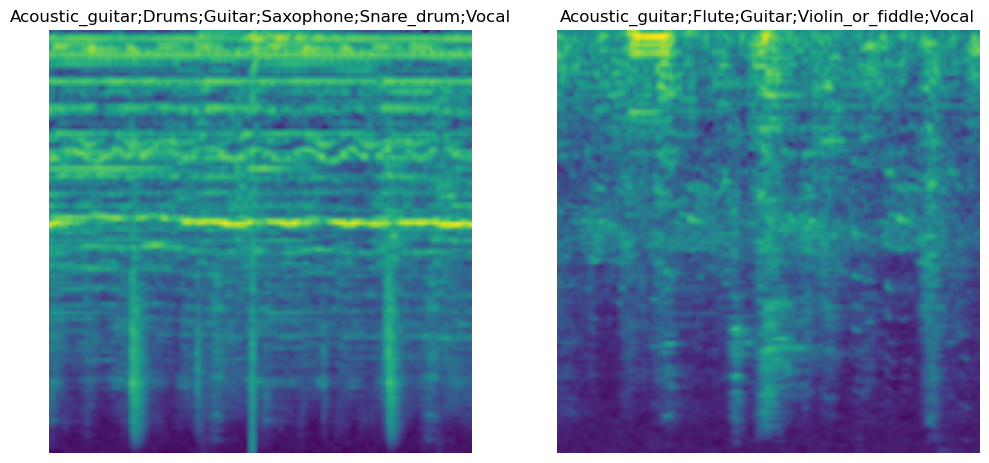

In [74]:
dls.show_batch(max_n=2, figsize=(12, 6))

In [75]:
from torch.nn import BCEWithLogitsLoss

learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.7), loss_func=BCEWithLogitsLoss())

SuggestedLRs(valley=0.001737800776027143)


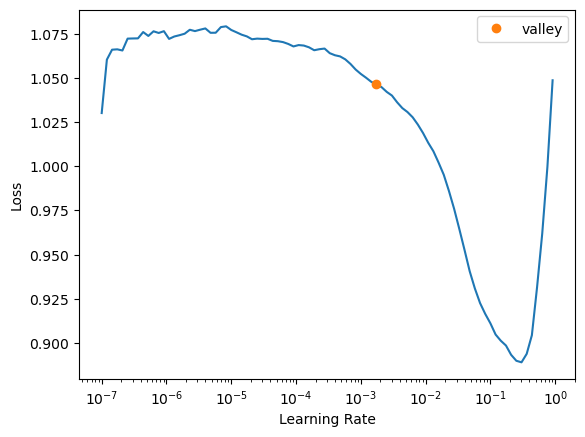

In [76]:
lr = learn.lr_find()
print(lr)

In [77]:
learn.fit_one_cycle(10, lr.valley)

KeyboardInterrupt: 

In [78]:
print(learn.recorder.values)

[[0.3841000199317932, 0.3390427529811859, 0.8481098413467407], [0.306443452835083, 0.2896276116371155, 0.8610246777534485], [0.2872898578643799, 0.2666677236557007, 0.8711826205253601], [0.27017921209335327, 0.255199670791626, 0.8771156072616577], [0.2608240842819214, 0.24655890464782715, 0.8805345892906189]]


In [79]:
# Get the predictions and targets
preds, targets = learn.get_preds()

# Convert the predictions to binary using a threshold
threshold = 0.7
binary_preds = (preds > threshold).int()

# Print the first few predictions and targets
for i in range(5):
    print(f"Predictions: {binary_preds[i]}, Targets: {targets[i]}")

Predictions: tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1], dtype=torch.int32), Targets: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1.])
Predictions: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1], dtype=torch.int32), Targets: tensor([1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1.])
Predictions: tensor([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1], dtype=torch.int32), Targets: tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.])
Predictions: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1], dtype=torch.int32), Targets: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0

In [80]:
class_names = dls.vocab
print(class_names)

['Acoustic_guitar', 'Bass', 'Bass_drum', 'Cello', 'Chime', 'Clarinet', 'Cowbell', 'Drums', 'Electric_guitar', 'Electric_piano', 'Finger_snapping', 'Flute', 'Glockenspiel', 'Gong', 'Guitar', 'Harmonica', 'Hi-hat', 'Oboe', 'Organ', 'Piano', 'Saxophone', 'Snare_drum', 'Tambourine', 'Trumpet', 'Violin_or_fiddle', 'Vocal']


In [81]:
# Get the predictions and targets
preds, targets = learn.get_preds()

# Convert the predictions to binary using a threshold
threshold = 0.7
binary_preds = (preds > threshold).int()

# Convert tensors to numpy arrays
binary_preds_np = binary_preds.numpy()
targets_np = targets.numpy()

# Print the first 5 predictions and targets
for i in range(5):
    predicted_labels = [class_names[j] for j in range(len(class_names)) if binary_preds_np[i][j]==1]
    actual_labels = [class_names[j] for j in range(len(class_names)) if targets_np[i][j]==1]
    print(f"Predicted labels: {predicted_labels}, Actual labels: {actual_labels}")

Predicted labels: ['Bass_drum', 'Drums', 'Gong', 'Tambourine', 'Vocal'], Actual labels: ['Drums', 'Electric_piano', 'Gong', 'Tambourine', 'Vocal']
Predicted labels: ['Acoustic_guitar', 'Hi-hat', 'Organ', 'Vocal'], Actual labels: ['Acoustic_guitar', 'Bass_drum', 'Drums', 'Guitar', 'Hi-hat', 'Organ', 'Vocal']
Predicted labels: ['Acoustic_guitar', 'Bass_drum', 'Electric_guitar', 'Vocal'], Actual labels: ['Acoustic_guitar', 'Bass_drum', 'Electric_guitar', 'Electric_piano', 'Finger_snapping', 'Guitar', 'Vocal']
Predicted labels: ['Drums', 'Snare_drum', 'Vocal'], Actual labels: ['Acoustic_guitar', 'Electric_piano', 'Snare_drum', 'Vocal']
Predicted labels: [], Actual labels: ['Acoustic_guitar', 'Bass', 'Clarinet', 'Violin_or_fiddle']


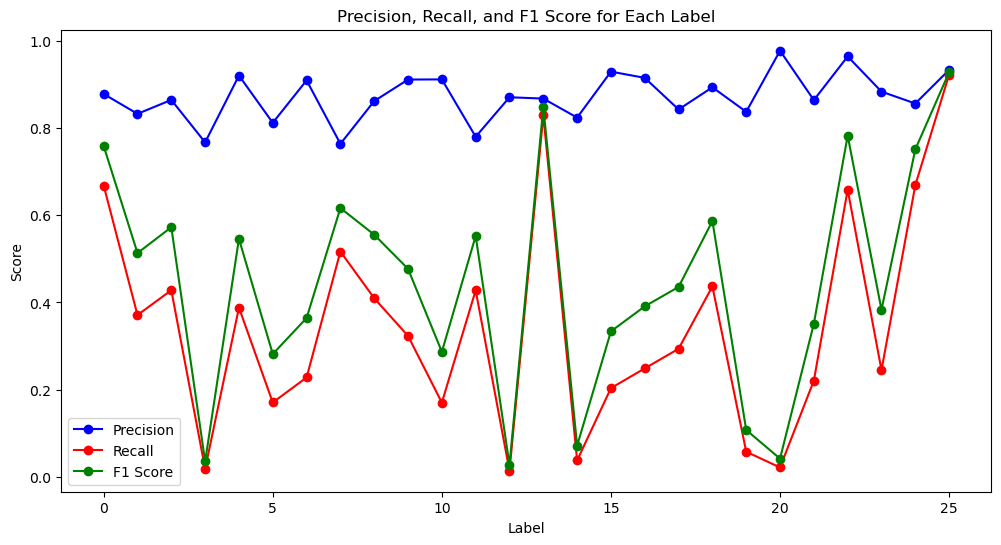

In [82]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1 score for each label
precision, recall, f1, _ = precision_recall_fscore_support(targets_np, binary_preds_np)

# Plot the metrics
plt.figure(figsize=(12, 6))
x = range(len(precision))
plt.plot(x, precision, marker='o', linestyle='-', color='b', label='Precision')
plt.plot(x, recall, marker='o', linestyle='-', color='r', label='Recall')
plt.plot(x, f1, marker='o', linestyle='-', color='g', label='F1 Score')
plt.xlabel('Label')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score for Each Label')
plt.legend()
plt.show()

In [85]:
learn.export(os.path.join(DATA_DIR, '..', 'models', 'instrument_classifier4.pkl'))